# Traffic Signs detection for TensorFlow Lite

This notebook shows how to train simple classification TensorFlow Lite model for traffic signs detection. We'll use retraining techniques on top of MobileNet v1 convolutional neural network. Like in the other project in the series - [MNIST for TFLite](https://github.com/frogermcs/MNIST-TFLite), we'll focus more on how to plugin and utilize the model on mobile app than on training high accuracy deep learning network.

Inspiration for this project comes from two entry-level codelabs **TensorFlow For Poets**:

[TensorFlow For Poets](https://codelabs.developers.google.com/codelabs/tensorflow-for-poets/index.html#0)  
[TensorFlow For Poets 2 - TFLite Android](https://codelabs.developers.google.com/codelabs/tensorflow-for-poets-2-tflite/index.html)

In fact, some parts of code here are just copy and paste of solutions described in those two articles. If you haven't done it yet, I highly recommend to start from reading and implementing of what's described there.

## Prerequisites

Add **TensorFlow Hub** dependency. This is the place where you can find pretrained, reusable Machine Learning components, like MobileNet and others. For more information, visit the [TensorFlow Hub website](https://www.tensorflow.org/hub).

In [ ]:
!pip install tensorflow_hub

In [ ]:
from PIL import Image
import os

import tensorflow as tf
import numpy as np
import tensorflow_hub as hub

import matplotlib
import matplotlib.pyplot as plt

import zipfile
import csv
import random

### Output configuration

Directories where we'll store notebook output - TensorFlow Lite model and labels for classification.

In [ ]:
OUTPUT_ROOT_DIR = "output/"
OUTPUT_RETRAINED_GRAPH = os.path.join(OUTPUT_ROOT_DIR, "retrained_graph_mv1_100_224.pb")
OUTPUT_TFLITE_MODEL = os.path.join(OUTPUT_ROOT_DIR, "retrained_graph_mv1_100_224.lite")
OUTPUT_LABELS = os.path.join(OUTPUT_ROOT_DIR, "retrained_labels_mv1_100_224.txt")
OUTPUT_READABLE_LABELS = os.path.join(OUTPUT_ROOT_DIR, "labels_readable.txt")

### Model configuration

Model input configuration comes from MobileNet network that we selected. Here we picked the one that has input image size 224x224 (you can see it in the url name). Other possible values of MobileNet v1: 192, 160, 128. The lower input value is, the faster model, but of course speed improvement isn't for free - smaller input size also results with worse accuracy (see more in the [blog post](https://ai.googleblog.com/2017/06/mobilenets-open-source-models-for.html)).

Mean and Std values are specific for MobileNet networks, and can be different from the others like Inception.

For more information, just visit url presented below.

In [ ]:
SELECTED_MOBILENET = "https://tfhub.dev/google/imagenet/mobilenet_v1_100_224/feature_vector/1"

MODEL_INPUT_HEIGHT = 224
MODEL_INPUT_WIDTH = 224
MODEL_INPUT_MEAN = 0
MODEL_INPUT_STD = 255

#Input layer of MobileNet v1 has constant name called "Placeholder"
MODEL_INPUT_LAYER_NAME = "Placeholder"
#Output layer can be defined by us, default one is "final_result"
MODEL_OUTPUT_LAYER_NAME = "final_result"

## Dataset

Our dataset comes from **GTSRB** - The German Traffic Sign Recognition Benchmark ([website](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset), [kaggle](https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign)). It contains more than 40 classes and more than 50,000 images of traffic signs, which are prepared for multi-class, single-image classification challenge. Base on it we'll build simple classifier that can be used in mobile application (or any other TensorFlow Lite project).

In [ ]:
TMP_DATA_DIR = "dataset/tmp"
TMP_LABELS_DIR = os.path.join(TMP_DATA_DIR, "GTSRB/Final_Test")

TRAINING_DATA_DIR = "dataset/training"
VALIDATION_DATA_DIR = "dataset/validation"

In [ ]:
#Fetch images deom GTSRB website
#Images for training
!curl -LO https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
#Images for validation    
!curl -LO https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
#Labels for validation
!curl -LO https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip

In [ ]:
%%time
to_unpack = [
    ("GTSRB_Final_Training_Images.zip", TMP_DATA_DIR),
    ("GTSRB_Final_Test_Images.zip", TMP_DATA_DIR),
    ("GTSRB_Final_Test_GT.zip", TMP_LABELS_DIR),
]

for file, directory in to_unpack:
    print("Unzipping {} to {}...".format(file, directory))
    with zipfile.ZipFile(file,"r") as zip_ref:
        zip_ref.extractall(directory)

### Prepare training, validation and labels

#### Labels

Originally dataset operates on numerical labels (e.g. "00000"). Let's make it human-readable.  
Labels will be saved in `/output` directory - they can be used together with final TensorFlow Lite model.

In [8]:
label_map = {
    0: '20_speed',
    1: '30_speed',
    2: '50_speed',
    3: '60_speed',
    4: '70_speed',
    5: '80_speed',
    6: '80_lifted',
    7: '100_speed',
    8: '120_speed',
    9: 'no_overtaking_general',
    10: 'no_overtaking_trucks',
    11: 'right_of_way_crossing',
    12: 'right_of_way_general',
    13: 'give_way',
    14: 'stop',
    15: 'no_way_general',
    16: 'no_way_trucks',
    17: 'no_way_one_way',
    18: 'attention_general',
    19: 'attention_left_turn',
    20: 'attention_right_turn',
    21: 'attention_curvy',
    22: 'attention_bumpers',
    23: 'attention_slippery',
    24: 'attention_bottleneck',
    25: 'attention_construction',
    26: 'attention_traffic_light',
    27: 'attention_pedestrian',
    28: 'attention_children',
    29: 'attention_bikes',
    30: 'attention_snowflake',
    31: 'attention_deer',
    32: 'lifted_general',
    33: 'turn_right',
    34: 'turn_left',
    35: 'turn_straight',
    36: 'turn_straight_right',
    37: 'turn_straight_left',
    38: 'turn_right_down',
    39: 'turn_left_down',
    40: 'turn_circle',
    41: 'lifted_no_overtaking_general',
    42: 'lifted_no_overtaking_trucks'
}

if not os.path.exists(OUTPUT_ROOT_DIR):
        os.makedirs(OUTPUT_ROOT_DIR)

file = open(OUTPUT_READABLE_LABELS, 'w')
for key, val in sorted(label_map.items()):
    file.write("{}\n".format(val))
file.close()

#### Training dataset

The only tricky part of GTSRB dataset is that images are stored as [*.ppm](https://en.wikipedia.org/wiki/Netpbm_format) files, which aren't supported by TensorFlow by default. To make it possible we need to convert them to .jpg files.

In [9]:
# Collect all PPM files and their labels

tmp_train_data_dir = os.path.join(TMP_DATA_DIR, "GTSRB/Final_Training/Images")

# Get all subdirectories of data_dir. Each represents a label.
directories = [d for d in os.listdir(tmp_train_data_dir) 
               if os.path.isdir(os.path.join(tmp_train_data_dir, d))]
# Loop through the label directories and collect the data in two lists, labels and images.
ppm_files_train = []
ppm_labels_train = []
for class_directory in directories:
    label_dir = os.path.join(tmp_train_data_dir, class_directory)
    file_names = [os.path.join(label_dir, f) 
                  for f in os.listdir(label_dir) if f.endswith(".ppm")]
    # For each label, load it's images and add them to the images list.
    # And add the label number (i.e. directory name) to the labels list.
    for image_file in file_names:
        ppm_files_train.append(image_file)
        ppm_labels_train.append(class_directory)
        
# Let's have it sorted for better debugging.
ppm_files_train.sort()
ppm_labels_train.sort()

In [10]:
%%time
# Convert
# from: dataset/Final_Training/Images/00000/00000_00000.ppm
# to:   dataset/training/00000/00000_00000.jpg

for ppm_file, label in zip(ppm_files_train, ppm_labels_train):
    image = Image.open(ppm_file)
    directory = os.path.join(TRAINING_DATA_DIR, label)
    image_filename = "{}.jpg".format(os.path.splitext(os.path.basename(ppm_file))[0])

    if not os.path.exists(directory):
        os.makedirs(directory)
    
    image.save(os.path.join(directory, image_filename))

CPU times: user 19.2 s, sys: 17.8 s, total: 37 s
Wall time: 3min 53s


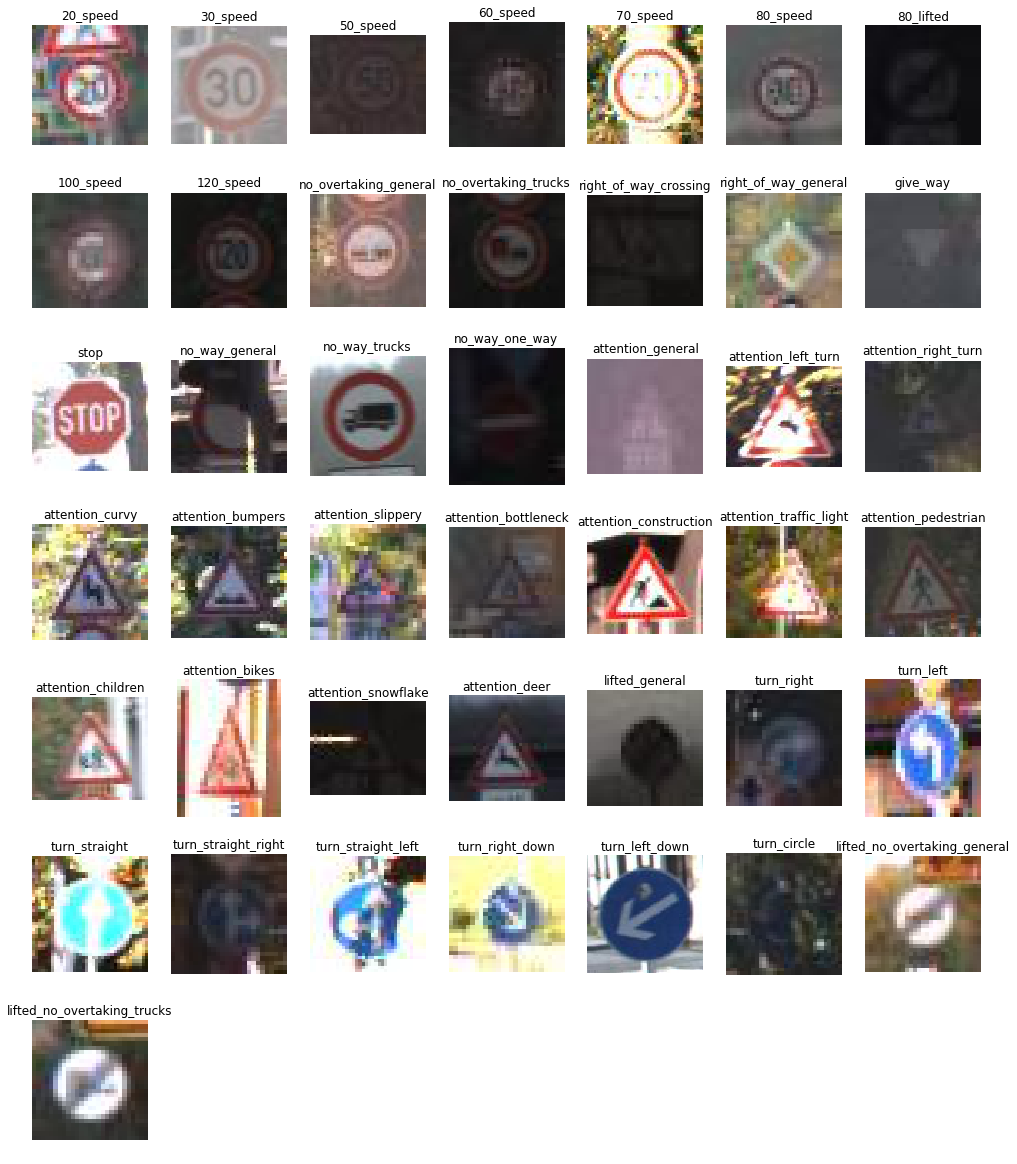

In [11]:
# Print all categories with example image for each of them.
preprocessed_training_dirs = [d for d in os.listdir(TRAINING_DATA_DIR) 
               if os.path.isdir(os.path.join(TRAINING_DATA_DIR, d))]
preprocessed_training_dirs.sort()

training_images = []
for training_dir in preprocessed_training_dirs:
    training_images.append(os.path.join(TRAINING_DATA_DIR, training_dir, "00000_00000.jpg"))

i = 0
plt.figure(figsize=(17, 30))
for image in training_images:
    plt.subplot(10,7, i + 1)
    plt.axis('off')
    plt.title("{}".format(label_map[i]))
    i += 1
    plt.imshow(Image.open(image))
plt.show()

#### Validation dataset

In [12]:
#Load testing set
tmp_validation_data_dir = os.path.join(TMP_DATA_DIR, "GTSRB/Final_Test/Images")

In [13]:
%%time

tmp_validation_data_files = [f for f in os.listdir(tmp_validation_data_dir) if f.endswith(".ppm")]
validation_images = []

#export as JPGs
for ppm_file in tmp_validation_data_files:
    image_dir = os.path.join(tmp_validation_data_dir, ppm_file) 
    image = Image.open(image_dir)
    directory = VALIDATION_DATA_DIR
    image_filename = "{}.jpg".format(os.path.splitext(os.path.basename(ppm_file))[0])

    if not os.path.exists(directory):
        os.makedirs(directory)
        
    final_image = os.path.join(directory, image_filename)
    image.save(final_image)

    validation_images.append(final_image)
    validation_images.sort()
    
print("Validation images count:", len(validation_images))

Validation images count: 12630
CPU times: user 9.89 s, sys: 4.47 s, total: 14.4 s
Wall time: 1min 21s


#### Validation dataset labels

In [14]:
#Load CSV labels    
tmp_validation_labels_csv = os.path.join(TMP_LABELS_DIR, "GT-final_test.csv")
validation_labels = []

with open(tmp_validation_labels_csv) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=';')
    line_count = 0
    for row in csv_reader:
        if (line_count > 0):
            validation_labels.append(int(row[7]))
        line_count += 1

print("Test labels count:", len(validation_labels))

Test labels count: 12630


Print some images from validation dataset with their labels.

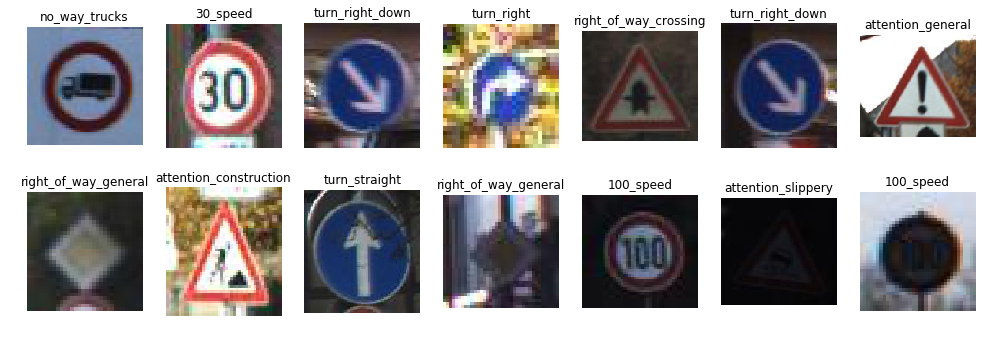

In [15]:
plt.figure(figsize=(17, 30))
for i in range(0, 14):
    image = validation_images[i]
    label_index = validation_labels[i]
    plt.subplot(10,7, i + 1)
    plt.axis('off')
    plt.title(label_map[label_index])
    plt.imshow(Image.open(image))
plt.show()

## Training process

Similarly to examples presented in [TensorFlow for Poets](https://codelabs.developers.google.com/codelabs/tensorflow-for-poets/index.html) codelab, we'll create our image classifier on top of MobileNet v1 by using transfer learning technique. Thanks to this, our training process will take no more than 2-3 hours (instead of days/weeks). More details about it can be found in [TensorFlow Tutorials - Image Retraining](https://www.tensorflow.org/hub/tutorials/image_retraining). 

For retraining, we'll run exactly the same script that was used in TensorFlow for Poets tutorial, with a bit different parameters that worked well for current dataset. 

In [16]:
!curl -LO https://github.com/tensorflow/hub/raw/master/examples/image_retraining/retrain.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   158  100   158    0     0    176      0 --:--:-- --:--:-- --:--:--   176
100 54640  100 54640    0     0  34545      0  0:00:01  0:00:01 --:--:--  883k


In [17]:
%%time
#Depending on machine configuration, this can take an hour or two.
!python -m retrain   \
--bottleneck_dir={OUTPUT_ROOT_DIR}bottlenecks \
--summaries_dir={OUTPUT_ROOT_DIR}training_summaries/mobilenet_100_224 \
--output_graph={OUTPUT_RETRAINED_GRAPH}  \
--output_labels={OUTPUT_LABELS} \
--tfhub_module {SELECTED_MOBILENET} \
--image_dir={TRAINING_DATA_DIR} \
--validation_batch_size=1000 \
--train_batch_size=100 \
--learning_rate=0.01 \
--print_misclassified_test_images \
--how_many_training_steps=10000

INFO:tensorflow:Looking for images in '00000'
INFO:tensorflow:Looking for images in '00001'
INFO:tensorflow:Looking for images in '00002'
INFO:tensorflow:Looking for images in '00003'
INFO:tensorflow:Looking for images in '00004'
INFO:tensorflow:Looking for images in '00005'
INFO:tensorflow:Looking for images in '00006'
INFO:tensorflow:Looking for images in '00007'
INFO:tensorflow:Looking for images in '00008'
INFO:tensorflow:Looking for images in '00009'
INFO:tensorflow:Looking for images in '00010'
INFO:tensorflow:Looking for images in '00011'
INFO:tensorflow:Looking for images in '00012'
INFO:tensorflow:Looking for images in '00013'
INFO:tensorflow:Looking for images in '00014'
INFO:tensorflow:Looking for images in '00015'
INFO:tensorflow:Looking for images in '00016'
INFO:tensorflow:Looking for images in '00017'
INFO:tensorflow:Looking for images in '00018'
INFO:tensorflow:Looking for images in '00019'
INFO:tensorflow:Looking for images in '00020'
INFO:tensorflow:Looking for images

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00000/00006_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00000/00006_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00000/00006_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00000/00005_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00000/00005_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00000/00000_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00000/00003_00022.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00000/00006_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00000/00006_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00000/00005_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00000/00005_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00000/00003_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00000/00003_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00000/00003_00029.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00000/00002_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00000/00004_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00000/00004_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00000/00004_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00000/00004_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00000/00002_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00000/00002_00015.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00000/00001_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00000/00004_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00000/00002_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:200 bottleneck files created.
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00000/00004_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00000/00006_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00000/00005_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottl

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00013_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00045_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00045_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00054_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00064_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00064_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00032_00011.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00039_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00040_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00051_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00070_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00070_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00018_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00061_00021.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00067_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00013_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00002_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00013_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00045_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00045_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00002_00008.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00062_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00034_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00034_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00073_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00025_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00016_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00007_00006.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00016_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00062_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00073_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00062_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00025_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00034_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00034_00010.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00045_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00002_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00054_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00067_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00048_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00048_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00059_00025.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00009_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00018_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00039_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00007_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00007_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00039_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00028_00023.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00002_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00013_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00045_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00013_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00059_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00048_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00031_00009.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00003_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00033_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00033_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00022_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00065_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00065_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00011_00018.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00063_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00038_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00050_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00029_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00041_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00006_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00038_00000.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00044_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00044_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00003_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00012_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00003_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00012_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00033_00012.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00063_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00050_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00050_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00017_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00029_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00017_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00006_00006.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00066_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00021_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00058_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00066_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00049_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00058_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00021_00010.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00072_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00063_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00063_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00063_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00072_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00035_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00024_00022.

INFO:tensorflow:1000 bottleneck files created.
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00021_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00030_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00021_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00058_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00066_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00049_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bott

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00035_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00035_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00024_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00024_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00063_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00072_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00063_00005.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00012_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00021_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00030_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00021_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00058_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00030_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00049_00001.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00029_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00017_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00041_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00038_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00006_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00038_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00050_00027.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00065_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00033_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00022_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00022_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00003_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00012_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00055_00029.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00017_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00029_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00006_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00041_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00050_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00041_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00063_00022.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00065_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00022_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00065_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00022_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00033_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00003_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00012_00027.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00008_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00071_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00036_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00036_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00008_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00060_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00008_00028.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00068_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00011_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00000_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00047_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00011_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00065_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00022_00010.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00042_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00014_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00008_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00008_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00036_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00019_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00060_00004.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00068_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00011_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00056_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00033_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00022_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00033_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00055_00004.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00059_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00020_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00031_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00031_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00002_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00002_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00013_00025.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00025_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00025_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00062_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00028_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00016_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00040_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00039_00021.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00073_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00020_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00067_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00059_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:1700 bottleneck files created.
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00059_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00067_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bott

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00067_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00048_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00034_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00073_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00073_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00025_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00034_00021.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00040_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00051_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00028_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00062_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00034_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00073_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00025_00002.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00067_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00048_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00067_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00031_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00031_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00073_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00025_00017.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00040_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00007_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00039_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00025_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00073_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00073_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00062_00024.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00067_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00059_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00031_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00031_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00034_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00062_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00025_00014.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00016_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00073_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00020_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00046_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00045_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00052_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00052_00008.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00019_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00065_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00058_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00030_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00033_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00000_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00068_00015.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00006_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00024_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00035_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00072_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00044_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00003_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00003_00013.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00028_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00073_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00031_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00002_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00046_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00059_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00034_00024.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00015_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00043_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00070_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00009_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00018_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00045_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00064_00015.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00050_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00035_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00035_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00072_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00041_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00027_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00042_00017.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00033_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00021_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00058_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00066_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00044_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00022_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00065_00025.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00043_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00016_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00051_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00028_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00028_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00048_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00001/00059_00029.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00045_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00045_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00002_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:2500 bottleneck files created.
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00054_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00013_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00020_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bott

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00026_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00070_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00061_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00070_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00016_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00028_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00051_00005.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00032_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00032_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00023_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00064_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00045_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00002_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00045_00004.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00070_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00009_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00070_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00037_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00026_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00018_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00009_00021.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00057_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00064_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00023_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00064_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00032_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00023_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00013_00017.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00043_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00052_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00061_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00070_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00026_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00018_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00061_00019.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00057_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00046_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00057_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00069_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00032_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00064_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00023_00026.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00049_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00058_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00044_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00044_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00055_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00055_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00003_00023.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00035_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00063_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00024_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00063_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00072_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00050_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00041_00020.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00021_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00066_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00058_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00021_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00058_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00049_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00049_00012.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00050_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00041_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00050_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00017_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00029_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00017_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00038_00017.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00049_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00058_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00021_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00021_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00003_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00012_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00012_00016.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00006_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00017_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00035_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00035_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00063_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00072_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00063_00012.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00065_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00044_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00044_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00055_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00012_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00003_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00012_00003.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00019_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00036_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00019_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00027_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00060_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00071_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00071_00016.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00047_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:3300 bottleneck files created.
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00056_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00000_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00011_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00022_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00033_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bott

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00053_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00071_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00060_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00027_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00019_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00036_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00008_00012.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00005_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00005_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00042_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00011_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00056_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00068_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00011_00004.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00074_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00074_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00022_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00068_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00000_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00047_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00056_00023.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00006_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00017_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00029_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00027_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00008_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00071_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00036_00001.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00030_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00003_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00012_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00044_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00003_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00044_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00055_00006.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00072_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00072_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00063_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00035_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00072_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00024_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00035_00024.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00021_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00030_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00030_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00058_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00021_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00066_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00049_00023.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00041_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00017_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00029_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00017_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00024_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00035_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00024_00001.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00022_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00065_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00074_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00074_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00033_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00055_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00044_00023.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00067_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00020_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00031_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00048_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00054_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00002_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00013_00025.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00028_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00040_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00040_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00007_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00061_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00061_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00026_00019.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00059_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00013_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00045_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00002_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00054_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00002_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00054_00017.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00028_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00007_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00039_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00028_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00051_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00040_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:4000 bottleneck files created.
INFO:tensorflow:Creating bott

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00031_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00067_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00020_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00031_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00067_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00059_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00059_00011.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00034_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00062_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00073_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00040_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00028_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00016_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00028_00014.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00034_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00025_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00048_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00031_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00020_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00031_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00059_00012.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00031_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00031_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00048_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00034_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00025_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00062_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00062_00025.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00064_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00002_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00031_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00073_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00070_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00037_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00015_00005.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00003_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00003_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00022_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00033_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00022_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00056_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00000_00000.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00058_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00030_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00012_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00014_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00017_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00041_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00024_00007.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00009_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00040_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00040_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00062_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00048_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00045_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00023_00015.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00013_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00020_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00039_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00061_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00015_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00037_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00009_00018.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00062_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00039_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00009_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00021_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00065_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00065_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00014_00017.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00042_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00068_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00068_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00065_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00012_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00021_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00049_00015.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00059_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00002_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00057_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00054_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00002_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00020_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00002/00059_00002.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00009_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00039_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00016_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00028_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00040_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00007_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00025_00025.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00018_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00015_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00004_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00043_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00015_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00004_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00043_00000.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00045_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00002_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00045_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:4800 bottleneck files created.
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00013_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00002_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00031_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bott

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00045_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00013_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00045_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00032_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00023_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00032_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00023_00018.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00016_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00039_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00007_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00007_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00039_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00040_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00025_00008.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00018_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00037_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00043_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00004_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00043_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00004_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00015_00007.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00019_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00005_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00042_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00005_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00042_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00014_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00000_00016.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00024_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00035_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00041_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00029_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00017_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00038_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00006_00006.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00014_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00019_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00027_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00008_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00036_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00027_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00036_00018.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00021_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00030_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00021_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00021_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00012_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00003_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00044_00017.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00042_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00005_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00042_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00000_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00000_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00011_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00022_00026.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00024_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00041_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00038_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00041_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00006_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00017_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00038_00021.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00042_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00014_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00036_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00019_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00027_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00036_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00038_00023.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00030_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00003_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00012_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00044_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00003_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00044_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00033_00022.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00000_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00011_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00000_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00033_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00022_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00003_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00021_00024.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00006_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00038_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00041_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00027_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00019_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00008_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00019_00025.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00045_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00013_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00032_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00032_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00023_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00001_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00010_00011.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00037_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:5600 bottleneck files created.
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00040_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00016_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00040_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00039_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00016_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bott

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00028_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00040_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00040_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00016_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00037_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00026_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00009_00010.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00010_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00001_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00046_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00046_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00023_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00032_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00023_00004.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00025_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00031_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00020_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00031_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00013_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00045_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00013_00020.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00015_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00018_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00039_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00007_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00039_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00020_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00020_00017.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00035_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00017_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00008_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00021_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00030_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00044_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00000_00005.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00007_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00010_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00007_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00039_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00004_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00018_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00009_00011.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00016_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00037_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00043_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00026_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00028_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00045_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00002_00026.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00036_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00008_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00017_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00035_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00006_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00036_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00003_00014.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00009_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00028_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00025_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00025_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00034_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00002_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00003/00010_00028.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00057_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00057_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00057_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00010_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00057_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00046_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00001_00016.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00015_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00009_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00018_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00018_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00026_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00037_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00037_00009.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00064_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00023_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00045_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00002_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00054_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00045_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00013_00012.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00051_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00007_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00039_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00039_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00007_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00016_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:6300 bottleneck files created.
INFO:tensorflow:Creating bott

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00054_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00048_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00048_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00020_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00059_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00020_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00034_00011.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00048_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00031_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00020_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00031_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00020_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00034_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00025_00021.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00000_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00042_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00014_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00053_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00005_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00042_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00060_00020.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00042_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00056_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00011_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00000_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00056_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00011_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00056_00000.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00042_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00008_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00036_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00060_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00019_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00027_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00027_00006.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00029_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00050_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00029_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00038_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00006_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00038_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00017_00025.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00003_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00012_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00030_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00021_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00058_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00049_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00058_00025.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00063_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00063_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00063_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00024_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00035_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00006_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00029_00022.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00055_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00012_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00055_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00003_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00033_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00022_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00033_00018.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00017_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00019_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00060_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00036_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00008_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00008_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00036_00002.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00065_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00022_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00033_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00022_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00022_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00000_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00047_00010.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00036_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00036_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00019_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00036_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00060_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00014_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00053_00011.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00056_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00000_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00047_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00014_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00053_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00042_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:7100 bottleneck files created.
INFO:tensorflow:Creating bott

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00000_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00047_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00047_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00011_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00000_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00047_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00011_00016.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00036_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00019_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00060_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00019_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00060_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00027_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00050_00022.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00011_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00056_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00022_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00033_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00022_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00065_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00033_00008.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00045_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00054_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00013_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00032_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00023_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00032_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00023_00003.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00043_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00052_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00043_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00052_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00043_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00015_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00052_00010.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00010_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00010_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00023_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00064_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00032_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00023_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00064_00024.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00043_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00052_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00009_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00061_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00018_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00037_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00009_00014.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00045_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00002_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00002_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00054_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00045_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00054_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00020_00018.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00018_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00016_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00007_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00039_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00016_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00028_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00051_00022.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00059_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00031_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00031_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00020_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00034_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00062_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00025_00014.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00039_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00061_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00009_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00009_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00052_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00009_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00037_00018.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00053_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00000_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00056_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00000_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00012_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00042_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00008_00009.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00047_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00003_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00049_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00058_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00055_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00065_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00053_00015.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00040_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00061_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00009_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00040_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00028_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00031_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00025_00017.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00048_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00045_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00023_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:7900 bottleneck files created.
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00046_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00010_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00032_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bott

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00036_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00056_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00056_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00058_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00065_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00047_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00035_00013.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00063_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00024_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00017_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00038_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00055_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00037_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00061_00001.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00023_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00057_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00010_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00046_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00032_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00013_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00004/00048_00020.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00001_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00057_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00010_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00046_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00057_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00057_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00010_00019.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00054_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00045_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00013_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00013_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00002_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00031_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00020_00000.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00051_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00016_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00025_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00034_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00034_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00059_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00031_00023.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00051_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00007_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00039_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00051_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00028_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00007_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00037_00025.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00013_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00002_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00032_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00023_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00032_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00057_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00010_00009.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00052_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00004_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00043_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00004_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00015_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00015_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00021_00002.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00024_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00035_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00035_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00024_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00041_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00038_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00050_00007.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00055_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00044_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00044_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00003_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00012_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00003_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00012_00013.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00006_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00038_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00029_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00008_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00027_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00008_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00014_00029.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00053_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00042_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00042_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00014_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00005_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00014_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00053_00008.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00047_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:8700 bottleneck files created.
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00056_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00011_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00000_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00000_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00047_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bott

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00019_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00050_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00041_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00017_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00041_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00006_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00038_00010.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00021_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00030_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00021_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00030_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00049_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00030_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00058_00017.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00041_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00038_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00041_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00006_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00017_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00029_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00038_00021.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00021_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00058_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00058_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00055_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00044_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00003_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00055_00017.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00036_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00036_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00008_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00019_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00060_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00036_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00060_00017.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00056_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00000_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00047_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00047_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00011_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00000_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00047_00028.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00019_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00027_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00041_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00038_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00006_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00017_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00029_00016.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00003_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00003_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00030_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00049_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00030_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00021_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00058_00007.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00046_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00057_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00010_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00057_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00010_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00001_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00032_00025.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00052_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00043_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00015_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00052_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00004_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00004_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00037_00014.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00010_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00010_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00023_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00023_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00032_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00023_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00054_00016.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00061_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00018_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00037_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00009_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00009_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00037_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00026_00022.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00045_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00059_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00048_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00059_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00020_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00031_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00031_00017.

INFO:tensorflow:9500 bottleneck files created.
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00007_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00039_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00016_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00028_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00040_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00007_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bott

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00034_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00025_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00025_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00025_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00039_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00040_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00007_00009.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00051_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00020_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00020_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00045_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00045_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00057_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00040_00026.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00044_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00027_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00027_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00006_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00050_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00006_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00024_00009.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00047_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00047_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00012_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00026_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00061_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00007_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00028_00007.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00040_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00007_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00025_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00048_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00013_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00023_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00057_00002.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00019_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00036_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00042_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00022_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00055_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00012_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00003_00019.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00041_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00005_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00022_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00030_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00049_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00021_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00055_00011.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00016_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00018_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00005/00052_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00006/00004_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00006/00004_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00006/00009_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00006/00007_00010.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00006/00013_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00006/00002_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00006/00007_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00006/00007_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00006/00009_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00006/00009_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00006/00004_00023.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00006/00006_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00006/00006_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00006/00006_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00006/00008_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00006/00008_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00006/00000_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00006/00011_00026.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00006/00003_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00006/00012_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00006/00012_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00006/00003_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00006/00012_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00006/00000_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00006/00011_00011.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00006/00008_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00006/00005_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00006/00000_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00006/00000_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00006/00011_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00006/00003_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00006/00012_00022.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00006/00009_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00006/00007_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00006/00013_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00006/00002_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00006/00002_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:10200 bottleneck files created.
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00006/00010_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bot

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00006/00013_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00006/00002_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00006/00013_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00006/00007_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00006/00007_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00006/00009_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00006/00009_00016.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00006/00007_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00006/00013_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00006/00001_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00006/00009_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00006/00001_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00006/00009_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00006/00007_00002.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00026_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00018_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00009_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00040_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00039_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00039_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00016_00023.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00039_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00016_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00040_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00018_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00018_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00026_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00009_00026.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00046_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00001_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00001_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00046_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00010_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00001_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00032_00013.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00007_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00016_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00040_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00016_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00025_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00034_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00020_00004.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00009_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00043_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00015_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00015_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00004_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00015_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00043_00010.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00034_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00025_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00025_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00007_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00040_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00039_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00007_00014.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00024_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00041_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00038_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00029_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00006_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00038_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00038_00014.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00011_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00005_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00014_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00042_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00014_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00008_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00036_00009.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00033_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00012_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00012_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00003_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00044_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00003_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00044_00004.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00017_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00008_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00036_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00036_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00019_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00027_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00027_00016.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00006_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00017_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00041_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00038_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00006_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00029_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00035_00013.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00003_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00012_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00022_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00033_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00022_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00033_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00047_00007.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00005_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:11000 bottleneck files created.
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00042_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00011_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00011_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00000_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00047_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bot

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00035_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00035_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00041_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00017_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00017_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00006_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00038_00022.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00047_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00014_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00042_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00014_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00005_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00019_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00008_00000.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00021_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00030_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00030_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00021_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00030_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00003_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00012_00020.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00005_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00042_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00014_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00005_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00042_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00011_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00011_00015.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00046_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00046_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00010_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00010_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00001_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00032_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00023_00002.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00007_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00034_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00025_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00034_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00020_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00031_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00020_00020.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00015_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00004_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00004_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00043_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00009_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00018_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00037_00011.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00016_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00028_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00028_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00039_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00037_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00026_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00018_00026.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00010_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00046_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00032_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00023_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00002_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00002_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00045_00023.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00015_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00026_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00025_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00034_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00020_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00013_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00032_00014.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00029_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00003_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00021_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00021_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00005_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00027_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00041_00012.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00018_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00013_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00002_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00010_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00010_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00032_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00023_00013.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00006_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00047_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00021_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00000_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00047_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:11700 bottleneck files created.
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00000_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bot

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00029_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00006_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00041_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00047_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00047_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00033_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00007/00009_00012.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00018_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00009_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00018_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00040_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00039_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00039_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00007_00004.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00039_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00040_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00018_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00018_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00026_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00009_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00037_00023.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00001_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00010_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00001_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00032_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00032_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00023_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00045_00010.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00002_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00002_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00013_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00045_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00032_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00032_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00046_00020.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00039_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00009_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00018_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00026_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00037_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00026_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00043_00005.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00027_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00019_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00005_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00042_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00042_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00014_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00005_00025.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00038_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00029_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00017_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00035_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00024_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00035_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00035_00014.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00014_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00005_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00019_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00027_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00008_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00036_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00027_00003.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00021_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00030_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00030_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00021_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00021_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00012_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00003_00026.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00042_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00011_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00000_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00011_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00022_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00033_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00033_00015.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00024_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00041_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00041_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00006_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00017_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00029_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00038_00021.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00036_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00008_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00019_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00027_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00036_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00008_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00038_00023.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00030_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00021_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00030_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:12500 bottleneck files created.
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00012_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00044_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00033_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bot

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00042_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00000_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00011_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00011_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00022_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00033_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00022_00004.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00035_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00024_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00038_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00017_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00029_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00029_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00017_00006.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00007_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00028_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00016_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00028_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00039_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00040_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00025_00010.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00009_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00015_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00004_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00004_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00043_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00043_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00015_00009.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00045_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00002_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00020_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00031_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00034_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00025_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00034_00021.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00002_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00032_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00023_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00023_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00046_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00001_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00046_00001.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00009_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00037_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00018_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00016_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00016_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00028_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00040_00005.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00009_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00037_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00018_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00037_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00009_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00043_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00004_00029.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00035_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00041_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00038_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00022_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00012_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00012_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00021_00004.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00004_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00016_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00010_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00032_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00007_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00026_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00043_00023.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00007_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00040_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00025_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00045_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00045_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00013_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00023_00024.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00027_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00019_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00006_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00006_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00000_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00005_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00027_00024.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00037_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00009_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00023_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00010_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00020_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00028_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00008/00007_00021.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00023_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00032_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00045_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00002_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00013_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00020_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00020_00003.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00020_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:13300 bottleneck files created.
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00020_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00013_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00002_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00045_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00045_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bot

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00043_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00043_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00015_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00004_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00015_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00043_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00043_00013.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00039_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00016_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00028_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00039_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00007_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00037_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00026_00002.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00010_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00001_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00001_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00001_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00010_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00010_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00046_00022.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00000_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00042_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00014_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00014_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00005_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00042_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00005_00018.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00021_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00021_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00030_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00021_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00030_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00021_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00021_00029.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00027_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00019_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00008_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00014_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00042_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00042_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00014_00015.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00006_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00038_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00017_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00035_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00035_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00024_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00035_00005.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00047_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00005_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00042_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00042_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00014_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00005_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00014_00006.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00021_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00030_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00021_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00030_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00021_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00030_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00030_00010.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00036_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00008_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00036_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00027_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00027_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00042_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00014_00023.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00017_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00041_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00035_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00035_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00024_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00024_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00024_00012.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00033_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00022_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00022_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00047_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00011_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00000_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00047_00015.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00022_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00033_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00022_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00044_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00003_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00012_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:14000 bottleneck files created.
INFO:tensorflow:Creating bot

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00029_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00038_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00041_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00019_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00036_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00008_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00019_00025.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00013_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00045_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00013_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00032_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00023_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00010_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00001_00022.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00018_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00026_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00009_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00037_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00037_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00040_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00016_00029.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00028_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00007_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00028_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00040_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00040_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00016_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00037_00029.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00001_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00001_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00046_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00046_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00023_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00023_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00045_00008.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00001_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00034_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00040_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00043_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00043_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00043_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00028_00019.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00036_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00000_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00022_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00033_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00033_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00044_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00033_00003.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00034_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00031_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00013_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00002_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00046_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00013_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00039_00003.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00027_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00019_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00038_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00024_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00027_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00008_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00019_00004.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00015_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00028_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00034_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00020_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00001_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00010_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00009/00023_00001.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00034_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00062_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00025_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00062_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00025_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00062_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00048_00011.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00062_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00028_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00039_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00040_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00007_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00007_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00016_00022.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00048_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00048_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00020_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00031_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00059_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:14800 bottleneck files created.
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00020_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bot

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00028_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00051_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00040_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00028_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00051_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00016_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00061_00022.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00045_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00002_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00054_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00045_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00013_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00023_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00064_00029.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00007_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00037_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00026_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00009_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00037_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00009_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00043_00012.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00032_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00032_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00064_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00064_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00046_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00057_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00010_00009.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00030_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00049_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00049_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00058_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00044_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00044_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00055_00021.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00063_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00050_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00041_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00038_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00029_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00041_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00006_00011.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00044_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00044_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00012_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00012_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00022_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00033_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00033_00012.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00017_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00017_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00038_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00006_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00006_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00038_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00029_00024.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00003_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00065_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00022_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00065_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00033_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00022_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00065_00029.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00050_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00036_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00060_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00019_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00027_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00019_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00008_00020.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00065_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00033_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00022_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00033_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00000_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00011_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00000_00012.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00019_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00060_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00027_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00036_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00005_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00014_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00042_00005.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00042_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00014_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00005_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00053_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00053_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00042_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00060_00001.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00042_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00011_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00056_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00011_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00000_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00047_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00056_00021.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00053_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00036_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00060_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:15600 bottleneck files created.
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00060_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00008_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00036_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bot

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00036_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00008_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00060_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00008_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00060_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00041_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00041_00006.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00047_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00011_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00022_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00022_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00065_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00055_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00044_00020.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00027_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00050_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00041_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00038_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00041_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00006_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00017_00007.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00055_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00012_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00003_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00003_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00030_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00049_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00030_00000.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00013_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00054_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00032_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00064_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00023_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00023_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00010_00005.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00052_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00043_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00052_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00043_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00052_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00015_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00052_00010.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00023_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00032_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00023_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00064_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00002_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00054_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00045_00025.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00051_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00028_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00039_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00007_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00016_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00040_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00051_00021.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00020_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00048_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00020_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00031_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00031_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00025_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00025_00003.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00051_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00040_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00040_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00007_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00062_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00025_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00034_00026.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00059_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00031_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00031_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00048_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00020_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00034_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00025_00000.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00039_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00016_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00062_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00048_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00045_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00032_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00057_00007.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00021_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00014_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00036_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00035_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00029_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00008_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00027_00016.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00044_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00066_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:16400 bottleneck files created.
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00012_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00000_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00053_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00006_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bot

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00026_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00009_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00004_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00016_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00023_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00046_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00064_00021.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00002_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00013_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00059_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00062_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00051_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00018_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00015_00012.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00044_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00000_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00014_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00008_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00050_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00063_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00038_00006.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00044_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00066_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00030_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00003_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00055_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00033_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00005_00000.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00054_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00051_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00009_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00004_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00025_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00020_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00010/00031_00015.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00032_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00032_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00002_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00013_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00013_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00020_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00020_00003.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00031_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00002_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00013_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00002_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00023_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00023_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00032_00006.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00028_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00007_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00039_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00039_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00007_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00016_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00040_00027.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00004_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00043_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00043_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00026_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00018_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00026_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00037_00027.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00007_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00009_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00018_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00026_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00026_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00018_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00037_00026.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00019_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00005_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00042_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00042_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00014_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00005_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00042_00028.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00035_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00024_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00017_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00029_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00017_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00038_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00006_00006.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00008_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00041_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00017_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00029_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00038_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00006_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00006_00002.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00033_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00022_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00033_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00000_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00000_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00011_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00042_00010.

INFO:tensorflow:17200 bottleneck files created.
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00012_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00003_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00012_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00021_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00030_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00021_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bot

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00036_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00027_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00019_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00027_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00042_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00014_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00005_00004.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00035_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00024_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00024_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00024_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00035_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00024_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00035_00009.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00008_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00041_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00041_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00029_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00017_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00038_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00006_00023.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00033_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00022_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00022_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00033_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00011_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00011_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00005_00028.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00011_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00000_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00011_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00022_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00033_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00022_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00033_00008.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00013_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00002_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00031_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00031_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00025_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00034_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00025_00011.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00010_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00001_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00001_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00001_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00010_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00010_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00023_00015.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00025_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00020_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00020_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00002_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00013_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00002_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00023_00005.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00037_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00018_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00028_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00007_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00039_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00040_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00040_00011.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00018_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00043_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00043_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00015_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00004_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00018_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00020_00016.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00008_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00014_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00000_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00027_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00008_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00036_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00029_00009.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00023_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00028_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00040_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00043_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00043_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00015_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00026_00027.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00023_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00007_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00009_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00015_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00015_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:17900 bottleneck files created.
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00039_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bot

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00006_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00036_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00014_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00021_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00021_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00012_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00011/00003_00010.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00004_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00043_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00043_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00015_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00015_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00004_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00037_00022.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00010_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00069_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00046_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00001_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00057_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00010_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00001_00002.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00043_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00004_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00015_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00009_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00018_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00018_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00037_00009.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00032_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00064_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00023_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00045_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00002_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00054_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00013_00012.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00028_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00039_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00007_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00051_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00040_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00028_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00062_00006.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00013_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00045_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00045_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00002_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00054_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00048_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00059_00025.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00051_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00040_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00007_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00051_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00025_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00062_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00062_00005.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00045_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00013_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00059_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00048_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00031_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00048_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00067_00023.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00068_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00047_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00068_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00011_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00000_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00000_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00056_00029.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00019_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00008_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00036_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00019_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00027_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00060_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00019_00029.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00056_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00000_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00056_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00068_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00000_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00000_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00047_00019.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00008_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00014_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00042_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00042_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00053_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00005_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00014_00001.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00022_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00065_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00047_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00000_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00068_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00056_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00047_00020.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00060_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00036_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00019_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:18700 bottleneck files created.
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00027_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00027_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00019_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bot

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00065_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00065_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00033_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00033_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00000_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00068_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00011_00021.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00019_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00060_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00027_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00036_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00005_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00014_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00014_00013.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00012_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00022_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00033_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00065_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00047_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00068_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00011_00005.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00029_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00017_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00019_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00036_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00008_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00008_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00036_00002.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00044_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00003_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00055_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00012_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00044_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00003_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00065_00019.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00006_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00038_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00029_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00027_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00008_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00036_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00019_00023.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00055_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00065_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00022_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00065_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00047_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00011_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00000_00024.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00060_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00008_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00019_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00036_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00008_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00005_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00053_00028.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00055_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00033_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00065_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00022_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00033_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00011_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00068_00008.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00006_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00038_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00050_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00041_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00027_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00060_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00008_00002.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00061_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00039_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00040_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00007_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00016_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00016_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00028_00007.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00002_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00048_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00031_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00020_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00031_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00048_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00067_00013.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00016_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00028_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00028_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00016_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00034_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00025_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00025_00013.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00002_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00013_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00002_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00031_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00059_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00020_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00031_00012.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00026_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:19500 bottleneck files created.
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00051_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00016_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00028_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00007_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00028_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bot

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00023_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00032_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00023_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00045_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00002_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00002_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00013_00022.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00061_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00061_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00026_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00018_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00026_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00009_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00037_00006.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00046_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00046_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00057_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00064_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00032_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00032_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00023_00013.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00023_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00069_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00009_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00004_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00015_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00052_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00015_00014.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00054_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00051_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00007_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00028_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00007_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00037_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00003_00023.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00008_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00038_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00006_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00060_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00068_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00021_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00030_00010.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00036_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00005_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00053_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00068_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00055_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00030_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00043_00008.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00057_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00032_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00020_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00034_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00051_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00026_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00015_00002.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00011_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00000_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00058_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00066_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00058_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00022_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00019_00027.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00009_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00025_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00062_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00020_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00054_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00054_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00012/00057_00019.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00045_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00054_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00064_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00064_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00032_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00032_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00023_00022.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00039_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00051_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00070_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00070_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00018_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00061_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:20200 bottleneck files created.
INFO:tensorflow:Creating bot

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00067_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00020_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00031_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00020_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00067_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00013_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00013_00013.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00016_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00039_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00039_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00007_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00028_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00051_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00040_00023.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00020_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00067_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00059_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00020_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00031_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00048_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00059_00024.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00034_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00025_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00034_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00062_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00040_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00051_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00016_00018.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00034_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00034_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00025_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00031_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00048_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00020_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00020_00013.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00013_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00059_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00048_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00031_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00048_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00067_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00020_00012.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00022_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00065_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00065_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00056_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00047_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00068_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00056_00015.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00038_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00006_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00017_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00060_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00019_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00008_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00019_00015.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00029_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00017_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00038_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00006_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00006_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00038_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00029_00024.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00012_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00012_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00044_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00044_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00003_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00044_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00065_00001.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00006_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00017_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00029_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00050_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00006_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00038_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00041_00026.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00049_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00030_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00021_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00021_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00012_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00055_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00003_00026.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00063_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00024_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00063_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00035_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00024_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00035_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00006_00014.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00030_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00066_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00058_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00058_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:21000 bottleneck files created.
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00066_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00055_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bot

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00041_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00006_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00050_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00017_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00029_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00038_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00041_00029.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00066_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00049_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00066_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00058_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00055_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00044_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00003_00029.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00017_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00029_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00006_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00038_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00017_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00029_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00008_00010.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00058_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00066_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00021_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00066_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00058_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00030_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00066_00028.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00035_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00024_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00063_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00035_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00035_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00024_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00024_00003.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00058_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00066_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00058_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00058_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00066_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00030_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00049_00021.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00024_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00035_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00024_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00063_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00017_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00029_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00029_00017.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00037_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00026_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00018_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00037_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00009_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00070_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00018_00009.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00010_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00001_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00023_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00023_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00032_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00064_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00045_00026.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00018_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00009_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00070_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00037_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00061_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00061_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00070_00025.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00002_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00013_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00045_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00002_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00031_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00059_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00020_00021.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00061_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00018_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00009_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00037_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00026_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00028_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00007_00023.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00013_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00054_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00045_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00054_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00067_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00059_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00059_00004.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00037_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00009_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00018_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00028_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00016_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00039_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00016_00013.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00002_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00054_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:21800 bottleneck files created.
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00045_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00054_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00067_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00031_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bot

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00045_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00069_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00001_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00045_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00015_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00015_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00052_00008.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00036_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00038_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00017_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00008_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00027_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00014_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00005_00023.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00017_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00008_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00008_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00071_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00014_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00005_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00053_00014.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00010_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00023_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00059_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00062_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00037_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00009_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00051_00009.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00013_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00034_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00007_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00028_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00009_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00026_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00039_00007.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00035_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00071_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00042_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00055_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00058_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00049_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00021_00004.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00024_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00017_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00047_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00066_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00030_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00011_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00047_00001.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00054_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00069_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00064_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00028_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00015_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00052_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00013/00061_00013.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00001_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00023_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00013_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00013_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00020_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00020_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00025_00024.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00015_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00015_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00009_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00018_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00018_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00007_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00007_00002.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00023_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00010_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00001_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00010_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00001_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00001_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00010_00020.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00022_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00003_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00012_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00021_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00021_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00021_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00012_00007.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00000_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00014_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00019_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00019_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00008_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00017_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00006_00016.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00005_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00014_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00011_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00000_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00000_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00011_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00022_00026.

INFO:tensorflow:22600 bottleneck files created.
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00003_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00022_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00022_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00000_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00011_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00000_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bot

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00008_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00017_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00006_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00017_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00024_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00024_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00024_00003.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00014_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00005_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00011_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00011_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00000_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00011_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00022_00013.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00016_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00016_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00016_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00025_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00025_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00020_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00013_00026.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00023_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00001_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00010_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00010_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00010_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00001_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00023_00010.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00016_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00016_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00007_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00009_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00018_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00009_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00004_00029.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00024_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00006_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00014_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00022_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00005_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00017_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00011_00007.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00009_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00007_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00001_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00002_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00021_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00012_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00000_00003.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00015_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00001_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00002_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00016_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00016_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00009_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00014/00009_00001.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00020_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00002_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00002_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00010_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00001_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00001_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00010_00026.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00015_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00015_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00004_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00004_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00018_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00009_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00018_00005.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00005_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00014_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00000_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00000_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00003_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00012_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00003_00008.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00006_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00017_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00006_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00017_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00019_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00019_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00014_00010.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00008_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00019_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00008_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:23300 bottleneck files created.
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00006_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00006_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00006_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bot

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00003_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00011_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00011_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00000_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00000_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00014_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00014_00024.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00011_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00012_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00012_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00003_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00015_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00004_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00009_00012.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00002_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00020_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00020_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00016_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00007_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00016_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00016_00028.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00007_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00020_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00013_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00002_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00002_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00010_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00001_00027.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00014_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00000_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00017_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00017_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00006_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00008_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00005_00023.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00007_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00020_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00001_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00013_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00004_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00010_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00015/00013_00028.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00004_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00009_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00007_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00007_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00001_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00001_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00010_00018.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00004_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00004_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00009_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00007_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00007_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00007_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00013_00029.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00006_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00006_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00008_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00008_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00005_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00000_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00000_00015.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00012_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00003_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00012_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00011_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00000_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00011_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00005_00005.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00012_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00003_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00012_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00000_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00011_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00011_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00005_00028.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00010_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00001_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00001_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00001_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00010_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00002_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00002_00014.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00007_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00009_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00004_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00004_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00004_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00010_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00010_00026.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00002_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00007_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00013_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00002_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00013_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00010_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00016/00010_00025.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00007_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:24100 bottleneck files created.
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00034_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00025_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00034_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00025_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00020_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bot

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00018_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00026_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00016_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00028_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00007_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00028_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00016_00020.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00015_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00004_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00015_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00009_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00026_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00018_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00018_00012.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00018_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00026_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00018_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00016_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00007_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00007_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00028_00023.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00004_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00004_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00015_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00015_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00021_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00030_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00021_00016.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00030_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00021_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00030_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00021_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00003_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00012_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00003_00020.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00000_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00000_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00022_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00012_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00012_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00003_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00021_00028.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00000_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00033_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00022_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00022_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00003_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00012_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00012_00003.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00005_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00011_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00000_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00000_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00011_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00022_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00033_00001.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00008_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00008_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00036_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00027_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00019_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00027_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00014_00023.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00006_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00017_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00029_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00027_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00008_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00036_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00008_00004.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00035_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00006_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00029_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00017_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00017_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00029_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00029_00028.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00017_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00024_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00024_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00024_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00024_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00035_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00024_00000.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00031_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00031_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00002_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00013_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00032_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00023_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:24800 bottleneck files created.
INFO:tensorflow:Creating bot

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00032_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00023_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00010_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00001_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00010_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00010_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00023_00015.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00013_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00002_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00032_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00023_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00023_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00001_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00010_00017.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00031_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00031_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00013_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00002_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00013_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00002_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00023_00012.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00025_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00009_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00032_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00002_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00034_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00007_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00007_00017.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00000_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00035_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00014_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00012_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00002_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00013_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00032_00024.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00033_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00027_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00019_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00006_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00006_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00006_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00000_00016.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00027_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00019_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00029_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00008_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00005_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00011_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00017/00026_00018.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00002_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00013_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00032_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00023_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00010_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00001_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00001_00017.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00034_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00025_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00034_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00034_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00020_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00020_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00031_00026.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00037_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00018_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00026_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00028_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00039_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00039_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00016_00025.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00015_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00015_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00004_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00004_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00004_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00026_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00026_00000.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00004_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00004_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00015_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00021_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00030_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00021_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00030_00019.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00012_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00030_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00021_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00021_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00030_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00021_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00030_00026.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00008_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00014_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00014_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00005_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00014_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00000_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00011_00026.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00029_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00017_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00008_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:25600 bottleneck files created.
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00019_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00027_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00008_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bot

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00035_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00006_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00029_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00017_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00038_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00006_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00006_00028.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00006_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00017_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00029_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00029_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00017_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00038_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00006_00019.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00036_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00019_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00027_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00036_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00008_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00017_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00017_00001.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00003_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00033_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00022_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00022_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00000_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00014_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00014_00024.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00003_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00012_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00033_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00022_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00022_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00033_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00000_00027.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00011_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00000_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00022_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00022_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00033_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00012_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00003_00006.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00039_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00007_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00016_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00028_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00007_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00039_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00026_00019.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00032_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00023_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00002_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00002_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00031_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00020_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00031_00012.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00010_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00001_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00010_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00001_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00023_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00032_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00002_00011.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00023_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00032_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00010_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00001_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00010_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00001_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00010_00001.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00037_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00018_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00007_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00007_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00015_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00018_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00039_00010.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00008_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00000_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00033_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00019_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00027_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00036_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00035_00022.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00009_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00023_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00001_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00013_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00025_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00037_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00018_00006.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00000_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00036_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00035_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00029_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00008_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00011_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00018/00022_00010.

INFO:tensorflow:26400 bottleneck files created.
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00019/00004_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00019/00004_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00019/00002_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00019/00001_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00019/00001_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00019/00001_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bot

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00019/00005_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00019/00000_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00019/00000_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00019/00000_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00019/00003_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00019/00003_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00019/00003_00025.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00019/00003_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00019/00003_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00019/00003_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00019/00003_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00019/00000_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00019/00000_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00019/00005_00003.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00019/00001_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00019/00001_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00019/00001_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00019/00002_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00019/00004_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00019/00004_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00019/00004_00000.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00020/00007_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00020/00001_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00020/00001_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00020/00010_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00020/00010_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00020/00010_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00020/00001_00002.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00020/00010_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00020/00001_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00020/00001_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00020/00001_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00020/00001_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00020/00010_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00020/00010_00008.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00020/00011_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00020/00000_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00020/00000_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00020/00003_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00020/00003_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00020/00003_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00020/00000_00006.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00020/00008_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00020/00005_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00020/00005_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00020/00000_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00020/00000_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00020/00003_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00020/00003_00000.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00020/00007_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00020/00002_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00020/00002_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00020/00010_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00020/00001_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00020/00010_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00020/00010_00004.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00020/00001_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00020/00010_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00020/00010_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00020/00010_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00020/00001_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00020/00010_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00020/00010_00029.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00020/00001_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00020/00010_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00020/00010_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00020/00002_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00020/00009_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00020/00007_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00020/00002_00013.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00021/00001_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00021/00001_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00021/00001_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00021/00001_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00021/00001_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00021/00010_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00021/00001_00015.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00021/00005_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00021/00008_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00021/00006_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00021/00006_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00021/00006_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00021/00006_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00021/00008_00025.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00021/00005_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00021/00000_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00021/00003_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00021/00003_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:27100 bottleneck files created.
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00021/00003_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00021/00003_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bot

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00021/00007_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00021/00007_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00021/00002_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00021/00010_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00021/00001_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00021/00010_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00021/00010_00004.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00021/00009_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00021/00009_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00021/00004_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00021/00004_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00021/00009_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00021/00009_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00021/00007_00008.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00021/00004_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00021/00002_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00021/00001_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00021/00004_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00021/00004_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00021/00004_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00021/00007_00020.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00022/00010_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00022/00010_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00022/00001_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00022/00010_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00022/00001_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00022/00002_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00022/00007_00011.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00022/00010_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00022/00010_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00022/00002_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00022/00007_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00022/00007_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00022/00004_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00022/00004_00020.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00022/00006_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00022/00008_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00022/00008_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00022/00000_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00022/00000_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00022/00003_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00022/00012_00017.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00022/00003_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00022/00003_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00022/00003_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00022/00003_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00022/00000_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00022/00011_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00022/00000_00021.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00022/00008_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00022/00006_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00022/00006_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00022/00006_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00022/00008_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00022/00008_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00022/00005_00015.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00022/00004_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00022/00009_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00022/00009_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00022/00009_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00022/00007_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00022/00002_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00022/00002_00010.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00022/00011_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00022/00008_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00022/00000_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00022/00012_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00022/00003_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00022/00000_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00022/00011_00023.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00022/00004_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00022/00001_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00022/00002_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00022/00007_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00022/00004_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00022/00001_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00004_00018.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00015_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00004_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00015_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00015_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00004_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00015_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00009_00009.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00015_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00015_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00012_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00003_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00012_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00011_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00000_00003.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00000_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00011_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00000_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00005_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00014_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00006_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00006_00002.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00006_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00006_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:27900 bottleneck files created.
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00008_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00008_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00014_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00005_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bot

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00014_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00000_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00011_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00000_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00011_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00003_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00003_00005.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00016_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00007_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00016_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00009_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00009_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00015_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00004_00010.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00016_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00016_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00009_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00009_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00009_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00015_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00004_00016.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00000_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00014_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00012_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00006_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00005_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00008_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00006_00017.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00001_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00010_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00013_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00006_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00014_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00014_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00023/00000_00001.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00024/00001_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00024/00001_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00024/00002_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00024/00002_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00024/00007_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00024/00004_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00024/00004_00022.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00024/00006_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00024/00006_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00024/00006_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00024/00008_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00024/00008_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00024/00000_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00024/00000_00029.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00024/00003_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00024/00003_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00024/00003_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00024/00003_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00024/00000_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00024/00000_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00024/00005_00012.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00024/00004_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00024/00007_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00024/00002_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00024/00002_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00024/00001_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00024/00001_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00024/00002_00003.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00024/00006_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00024/00000_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00024/00008_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00024/00006_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00024/00008_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00024/00008_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00024/00008_00023.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00028_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00040_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00007_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00039_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00025_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00025_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00048_00011.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00043_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00043_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00004_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00015_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00015_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00026_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00018_00017.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00020_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00048_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00048_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00034_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00034_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00025_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00016_00021.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00045_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00023_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00032_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00046_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00001_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00046_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00001_00005.

INFO:tensorflow:28700 bottleneck files created.
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00040_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00007_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00025_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00034_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00034_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00025_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bot

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00018_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00026_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00018_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00037_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00026_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00043_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00004_00008.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00041_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00006_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00038_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00038_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00006_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00027_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00019_00001.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00036_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00038_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00029_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00017_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00038_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00029_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00017_00008.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00012_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00044_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00044_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00022_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00033_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00000_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00000_00005.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00012_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00021_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00030_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00021_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00049_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00049_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00030_00008.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00006_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00006_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00041_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00027_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00019_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00019_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00027_00001.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00019_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00008_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00036_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00006_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00029_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00029_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00017_00016.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00030_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00030_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00021_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00021_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00049_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00003_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00012_00026.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00042_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00005_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00005_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00000_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00011_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00011_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00047_00005.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00017_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00029_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00024_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00035_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00035_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00035_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00024_00017.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00022_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00033_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00000_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00011_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00011_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00047_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00005_00028.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00000_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00022_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00033_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00022_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00033_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00044_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00012_00009.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00046_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00046_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00010_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00010_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:29400 bottleneck files created.
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00001_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00032_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bot

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00040_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00039_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00016_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00028_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00028_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00016_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00007_00026.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00037_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00026_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00037_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00009_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00009_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00018_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00004_00013.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00048_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00020_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00031_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00034_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00034_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00040_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00028_00028.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00046_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00010_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00010_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00010_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00010_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00001_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00010_00001.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00023_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00046_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00001_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00045_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00034_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00039_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00018_00016.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00005_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00030_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00003_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00022_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00047_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00011_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00014_00005.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00023_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00016_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00016_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00018_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00004_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00043_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00045_00024.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00002_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00013_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00032_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00023_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00010_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00001_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00002_00024.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00003_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00033_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00033_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00000_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00047_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00041_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00008_00023.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00013_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00020_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00034_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00007_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00015_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00004_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00025/00043_00026.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00001_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00010_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00002_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00013_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00013_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00007_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00007_00005.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00016_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00002_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00013_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00001_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00001_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00010_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00001_00004.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00014_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00019_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00019_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00008_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00006_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00017_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00006_00010.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00012_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00003_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00003_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00012_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00012_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00003_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00000_00011.

INFO:tensorflow:30200 bottleneck files created.
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00012_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00003_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00012_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00012_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00003_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00003_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bot

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00000_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00012_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00012_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00003_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00003_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00004_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00015_00022.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00010_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00002_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00002_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00013_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00002_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00016_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00016_00014.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00007_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00016_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00007_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00013_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00002_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00013_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00002_00007.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00011_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00005_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00014_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00006_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00005_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00014_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00014_00013.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00010_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00007_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00015_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00012_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00005_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00019_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00026/00014_00002.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00027/00007_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00027/00002_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00027/00001_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00027/00001_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00027/00001_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00027/00001_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00027/00002_00022.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00027/00006_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00027/00006_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00027/00005_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00027/00005_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00027/00000_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00027/00000_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00027/00003_00008.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00027/00006_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00027/00005_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00027/00005_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00027/00000_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00027/00000_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00027/00003_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00027/00003_00000.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00027/00002_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00027/00001_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00027/00001_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00027/00001_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00027/00002_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00027/00002_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00027/00007_00022.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00027/00003_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00027/00000_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00027/00005_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00027/00005_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00027/00000_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00027/00003_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00027/00005_00028.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00016_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00007_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00013_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00002_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00013_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00002_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00001_00014.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00016_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00007_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00007_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00007_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00013_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:30900 bottleneck files created.
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00002_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bot

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00012_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00000_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00000_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00000_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00011_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00005_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00014_00000.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00003_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00012_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00000_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00011_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00000_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00005_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00014_00012.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00012_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00003_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00012_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00003_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00012_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00003_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00003_00015.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00005_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00014_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00011_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00000_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00011_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00003_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00012_00022.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00016_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00007_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00007_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00009_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00004_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00004_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00015_00009.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00016_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00009_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00009_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00009_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00015_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00004_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00015_00025.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00017_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00006_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00011_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00017_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00017_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00005_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00014_00020.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00012_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00006_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00006_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00000_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00017_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00008_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00028/00014_00008.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00029/00007_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00029/00004_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00029/00004_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00029/00007_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00029/00007_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00029/00002_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00029/00002_00025.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00029/00005_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00029/00008_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00029/00006_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00029/00006_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00029/00008_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00029/00005_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00029/00005_00007.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00029/00007_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00029/00007_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00029/00004_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00029/00004_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00029/00004_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00029/00002_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00029/00002_00029.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00029/00007_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00029/00007_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00029/00004_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00029/00007_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00029/00007_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00029/00004_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00029/00007_00014.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00030/00001_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00030/00010_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00030/00001_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00030/00001_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00030/00010_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00030/00001_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00030/00002_00009.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00030/00007_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00030/00007_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00030/00004_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00030/00004_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:31700 bottleneck files created.
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00030/00012_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00030/00011_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bot

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00030/00011_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00030/00000_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00030/00014_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00030/00005_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00030/00014_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00030/00008_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00030/00008_00009.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00030/00000_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00030/00011_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00030/00005_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00030/00014_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00030/00005_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00030/00008_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00030/00006_00025.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00030/00006_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00030/00006_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00030/00008_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00030/00008_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00030/00008_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00030/00005_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00030/00014_00025.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00030/00001_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00030/00002_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00030/00013_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00030/00002_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00030/00007_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00030/00007_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00030/00009_00007.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00030/00009_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00030/00009_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00030/00007_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00030/00007_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00030/00002_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00030/00013_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00030/00002_00007.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00030/00010_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00030/00013_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00030/00002_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00030/00002_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00030/00010_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00030/00013_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00030/00010_00000.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00015_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00004_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00018_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00009_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00018_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00007_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00016_00023.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00002_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00023_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00023_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00001_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00001_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00010_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00001_00028.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00020_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00020_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00025_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00016_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00007_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00016_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00007_00017.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00021_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00021_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00012_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00003_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00012_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00022_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00011_00018.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00019_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00019_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00006_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00017_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00006_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00017_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00024_00026.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00014_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00014_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00011_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00000_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00000_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00022_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00022_00019.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00005_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00014_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00019_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00008_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00019_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00008_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:32400 bottleneck files created.
INFO:tensorflow:Creating bot

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00017_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00006_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00017_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00008_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00008_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00019_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00014_00008.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00003_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00003_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00012_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00021_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00021_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00003_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00012_00020.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00016_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00016_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00025_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00025_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00020_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00002_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00002_00002.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00001_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00001_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00001_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00010_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00010_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00023_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00023_00001.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00015_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00007_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00002_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00023_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00023_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00002_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00013_00012.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00016_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00004_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00015_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00004_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00013_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00001_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00001_00026.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00003_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00012_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00003_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00011_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00014_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00008_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00031/00017_00011.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00032/00007_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00032/00007_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00032/00002_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00032/00002_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00032/00001_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00032/00001_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00032/00002_00018.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00032/00006_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00032/00006_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00032/00005_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00032/00000_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00032/00000_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00032/00003_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00032/00003_00024.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00032/00005_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00032/00005_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00032/00006_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00032/00006_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00032/00006_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00032/00006_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00032/00005_00001.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00032/00004_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00032/00002_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00032/00002_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00032/00001_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00032/00004_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00032/00003_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00032/00003_00019.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00032/00002_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00004_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00015_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00015_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00018_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00018_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00009_00027.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00001_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00010_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00001_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00001_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00010_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00001_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00002_00009.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00009_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00018_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00007_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00020_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:33200 bottleneck files created.
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00020_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00013_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bot

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00005_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00014_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00000_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00011_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00022_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00012_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00012_00011.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00000_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00011_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00000_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00005_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00014_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00019_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00008_00021.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00014_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00005_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00011_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00000_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00011_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00022_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00012_00028.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00000_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00011_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00005_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00014_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00005_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00008_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00008_00011.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00011_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00000_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00011_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00003_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00003_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00012_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00021_00024.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00007_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00007_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00016_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00020_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00002_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00013_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00010_00005.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00016_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00009_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00009_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00018_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00004_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00004_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00015_00020.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00010_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00010_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00010_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00001_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00010_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00010_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00013_00021.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00014_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00017_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00017_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00008_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00003_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00012_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00000_00006.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00016_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00007_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00013_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00016_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00007_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00011_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00033/00000_00003.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00034/00002_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00034/00013_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00034/00010_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00034/00001_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00034/00001_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00034/00010_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00034/00010_00019.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00034/00007_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00034/00007_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00034/00009_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00034/00009_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00034/00004_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00034/00004_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00034/00004_00009.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00034/00005_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00034/00000_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00034/00011_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00034/00000_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00034/00000_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00034/00012_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00034/00012_00006.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00034/00012_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00034/00003_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00034/00003_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00034/00012_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00034/00000_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00034/00011_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00034/00005_00011.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00034/00008_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00034/00006_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:34000 bottleneck files created.
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00034/00006_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00034/00008_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00034/00008_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00034/00005_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bot

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00034/00007_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00034/00009_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00034/00009_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00034/00004_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00034/00004_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00034/00004_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00034/00004_00012.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00034/00001_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00034/00010_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00034/00013_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00034/00002_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00034/00002_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00034/00013_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00034/00007_00009.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00034/00009_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00034/00010_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00034/00001_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00034/00013_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00034/00011_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00034/00011_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00034/00000_00002.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00007_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00034_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00025_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00034_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00031_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00020_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00031_00025.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00028_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00007_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00039_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00028_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00039_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00034_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00034_00015.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00015_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00009_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00037_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00026_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00018_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00009_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00037_00024.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00015_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00004_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00015_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00004_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00026_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00018_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00026_00000.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00018_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00026_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00018_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00037_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00004_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00004_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00015_00007.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00011_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00000_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00011_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00033_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00033_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00003_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00012_00005.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00008_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00014_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00014_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00005_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00014_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00000_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00011_00026.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00006_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00017_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00029_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00006_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00038_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00029_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00017_00018.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00035_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00024_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00035_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00006_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00038_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00029_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00006_00028.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00035_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00024_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00038_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00006_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00017_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00029_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00038_00021.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00035_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00024_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00024_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00024_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00035_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00035_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00017_00028.

INFO:tensorflow:34800 bottleneck files created.
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00029_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00017_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00006_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00029_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00024_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00035_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bot

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00005_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00005_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00027_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00008_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00008_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00036_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00019_00024.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00026_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00039_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00007_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00007_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00028_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00016_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00016_00016.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00004_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00015_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00004_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00037_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00009_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00018_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00026_00027.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00018_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00004_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00015_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00015_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00004_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00004_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00015_00018.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00028_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00039_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00037_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00009_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00018_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00009_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00037_00010.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00025_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00025_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00039_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00007_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00039_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00028_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00016_00012.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00008_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00021_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00021_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00021_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00003_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00012_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00008_00018.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00036_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00019_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00035_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00027_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00030_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00021_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00009_00012.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00010_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00023_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00037_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00009_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00004_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00007_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00025_00008.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00022_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00003_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00030_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00003_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00000_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00036_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00017_00015.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00025_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00025_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00002_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00032_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00010_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00031_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00035/00034_00027.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00036/00002_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00036/00002_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00036/00007_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00036/00009_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00036/00009_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00036/00004_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00036/00004_00021.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00036/00006_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00036/00008_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00036/00005_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00036/00000_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00036/00011_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:35500 bottleneck files created.
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00036/00000_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bot

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00036/00005_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00036/00008_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00036/00008_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00036/00006_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00036/00006_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00036/00006_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00036/00008_00007.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00036/00012_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00036/00003_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00036/00012_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00036/00012_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00036/00000_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00036/00011_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00036/00011_00014.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00036/00010_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00036/00002_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00036/00002_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00036/00002_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00036/00007_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00036/00009_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00036/00004_00013.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00036/00011_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00036/00000_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00036/00006_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00036/00011_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00036/00005_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00036/00006_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00036/00011_00008.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00036/00008_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00036/00012_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00036/00000_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00036/00011_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00036/00012_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00036/00012_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00036/00000_00006.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00037/00002_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00037/00004_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00037/00004_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00037/00004_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00037/00002_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00037/00001_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00037/00001_00012.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00037/00006_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00037/00006_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00037/00005_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00037/00005_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00037/00000_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00037/00000_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00037/00003_00016.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00037/00005_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00037/00000_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00037/00003_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00037/00003_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00037/00004_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00037/00004_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00037/00002_00016.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00037/00003_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00037/00003_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00037/00005_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00037/00003_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00037/00000_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00037/00003_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00037/00001_00021.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00031_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00020_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00054_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00002_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00013_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00045_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00045_00006.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00051_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00018_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00061_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00018_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00061_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00026_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00009_00026.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00045_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00045_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00002_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00064_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00023_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00023_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00032_00006.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00018_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00037_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00009_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00015_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00004_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00015_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00052_00018.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00013_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00045_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00032_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00064_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00064_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00023_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00064_00015.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00007_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00037_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:36300 bottleneck files created.
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00026_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00018_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00018_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00026_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bot

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00057_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00010_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00057_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00010_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00001_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00001_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00010_00020.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00004_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00015_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00015_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00021_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00021_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00066_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00049_00011.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00024_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00035_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00063_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00024_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00063_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00063_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00050_00013.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00021_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00030_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00021_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00066_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00058_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00021_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00058_00021.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00035_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00035_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00035_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00024_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00063_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00063_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00041_00023.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00058_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00021_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00021_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00049_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00058_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00066_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00049_00017.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00050_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00006_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00041_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00050_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00017_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00050_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00008_00008.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00044_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00012_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00055_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00044_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00033_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00065_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00033_00014.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00006_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00006_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00050_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00050_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00041_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00027_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00060_00024.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00003_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00003_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00012_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00022_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00033_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00022_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00033_00018.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00029_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00038_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00041_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00029_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00017_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00019_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00060_00028.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00055_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00012_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00044_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00003_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00003_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00065_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00022_00000.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00017_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00008_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00036_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00036_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00008_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00019_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00060_00003.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00055_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00065_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00033_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00022_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00047_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00011_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00011_00003.

INFO:tensorflow:37100 bottleneck files created.
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00060_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00008_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00036_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00027_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00019_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00005_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bot

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00022_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00022_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00000_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00011_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00068_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00011_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00047_00002.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00019_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00027_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00008_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00036_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00014_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00005_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00042_00024.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00007_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00028_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00016_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00028_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00039_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00025_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00062_00009.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00062_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00034_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00028_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00016_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00040_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00007_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00016_00003.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00025_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00062_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00034_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00020_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00067_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00059_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00048_00027.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00067_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00048_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00025_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00034_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00025_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00016_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00028_00011.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00034_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00031_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00067_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00020_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00031_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00067_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00059_00005.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00034_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00040_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00028_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00051_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00040_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00007_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00016_00005.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00048_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00031_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00054_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00054_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00045_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00002_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00013_00020.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00028_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00007_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00037_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00026_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00009_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00018_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00061_00011.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00026_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00025_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00034_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00020_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00048_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00064_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00001_00006.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00060_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00036_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00019_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00008_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00053_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00053_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00022_00025.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00041_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00050_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00008_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00053_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00042_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:37800 bottleneck files created.
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00022_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bot

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00028_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00039_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00009_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00015_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00043_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00026_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00009_00017.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00043_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00052_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00052_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00026_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00051_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00034_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00025_00020.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00033_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00044_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00058_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00011_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00019_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00019_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00006_00014.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00024_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00024_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00006_00021.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00053_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00056_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00003_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00049_00008.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00013_00009.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00034_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00039_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00039_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00028_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00018_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00038/00052_00003.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00039/00009_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00039/00007_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00039/00007_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00039/00007_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00039/00002_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00039/00001_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00039/00001_00012.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00039/00006_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00039/00006_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00039/00008_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00039/00008_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00039/00000_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00039/00003_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00039/00003_00024.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00039/00008_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00039/00008_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00039/00008_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00039/00006_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00039/00006_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00039/00008_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00039/00008_00015.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00039/00001_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00039/00002_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00039/00002_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00039/00002_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00039/00009_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00039/00009_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00039/00004_00007.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00039/00005_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00039/00006_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00039/00005_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00039/00000_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00039/00006_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00039/00006_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00039/00000_00013.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00040/00004_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00040/00009_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00040/00009_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00040/00007_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00040/00007_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00040/00002_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00040/00002_00008.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00040/00005_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00040/00005_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00040/00008_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00040/00005_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00040/00005_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00040/00000_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00040/00011_00025.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00040/00008_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00040/00006_00029.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00040/00006_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00040/00006_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00040/00008_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00040/00005_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00040/00005_00008.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00040/00011_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00040/00000_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00040/00000_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00040/00005_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00040/00008_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00040/00008_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00040/00006_00022.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00040/00007_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00040/00009_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00040/00009_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:38600 bottleneck files created.
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00040/00004_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00040/00004_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00040/00009_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bot

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00040/00009_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00040/00004_00015.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00040/00001_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00040/00007_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00040/00009_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00040/00004_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00040/00001_00000.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00041/00004_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00041/00007_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00041/00007_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00041/00002_00019.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00041/00001_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00041/00001_00005.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00041/00001_00004.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00041/00006_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00041/00006_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00041/00006_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00041/00005_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00041/00000_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00041/00003_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00041/00003_00024.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00041/00003_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00041/00000_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00041/00005_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00041/00005_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00041/00006_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00041/00006_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00041/00006_00021.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00041/00002_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00041/00002_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00041/00001_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00041/00001_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00041/00002_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00041/00004_00001.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00041/00004_00015.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00042/00004_00024.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00042/00007_00004.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00042/00007_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00042/00002_00023.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00042/00001_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00042/00001_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00042/00001_00016.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00042/00003_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00042/00003_00020.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00042/00000_00028.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00042/00000_00014.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00042/00000_00000.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00042/00005_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00042/00006_00013.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00042/00005_00006.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00042/00005_00012.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00042/00006_00026.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00042/00006_00027.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00042/00005_00013.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00042/00005_00007.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00042/00000_00020.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00042/00001_00018.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00042/00001_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00042/00002_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00042/00007_00022.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00042/00004_00016.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00042/00004_00002.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00042/00004_00000.

INFO:tensorflow:Creating bottleneck at output/bottlenecks/00042/00002_00025.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00042/00007_00003.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00042/00007_00017.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00042/00004_00008.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00042/00006_00010.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00042/00006_00011.jpg_https~tfhub.dev~google~imagenet~mobilenet_v1_100_224~feature_vector~1.txt
INFO:tensorflow:Creating bottleneck at output/bottlenecks/00042/00005_00025.

INFO:tensorflow:2019-02-18 21:30:14.586146: Step 170: Validation accuracy = 63.1% (N=1000)
INFO:tensorflow:2019-02-18 21:30:18.507701: Step 180: Train accuracy = 68.0%
INFO:tensorflow:2019-02-18 21:30:18.507967: Step 180: Cross entropy = 1.899781
INFO:tensorflow:2019-02-18 21:30:23.296073: Step 180: Validation accuracy = 57.3% (N=1000)
INFO:tensorflow:2019-02-18 21:30:27.883912: Step 190: Train accuracy = 61.0%
INFO:tensorflow:2019-02-18 21:30:27.884115: Step 190: Cross entropy = 1.902051
INFO:tensorflow:2019-02-18 21:30:32.724732: Step 190: Validation accuracy = 60.8% (N=1000)
INFO:tensorflow:2019-02-18 21:30:37.681309: Step 200: Train accuracy = 61.0%
INFO:tensorflow:2019-02-18 21:30:37.681490: Step 200: Cross entropy = 1.966294
INFO:tensorflow:2019-02-18 21:30:41.746604: Step 200: Validation accuracy = 63.5% (N=1000)
INFO:tensorflow:2019-02-18 21:30:45.463755: Step 210: Train accuracy = 64.0%
INFO:tensorflow:2019-02-18 21:30:45.463952: Step 210: Cross entropy = 1.926972
INFO:tensorf

INFO:tensorflow:2019-02-18 21:34:48.637649: Step 510: Train accuracy = 75.0%
INFO:tensorflow:2019-02-18 21:34:48.637931: Step 510: Cross entropy = 1.247848
INFO:tensorflow:2019-02-18 21:34:52.285567: Step 510: Validation accuracy = 74.9% (N=1000)
INFO:tensorflow:2019-02-18 21:34:56.748317: Step 520: Train accuracy = 78.0%
INFO:tensorflow:2019-02-18 21:34:56.748513: Step 520: Cross entropy = 1.169923
INFO:tensorflow:2019-02-18 21:35:01.008284: Step 520: Validation accuracy = 73.1% (N=1000)
INFO:tensorflow:2019-02-18 21:35:05.388561: Step 530: Train accuracy = 78.0%
INFO:tensorflow:2019-02-18 21:35:05.388755: Step 530: Cross entropy = 1.134254
INFO:tensorflow:2019-02-18 21:35:09.677628: Step 530: Validation accuracy = 71.8% (N=1000)
INFO:tensorflow:2019-02-18 21:35:13.835729: Step 540: Train accuracy = 76.0%
INFO:tensorflow:2019-02-18 21:35:13.835955: Step 540: Cross entropy = 1.364139
INFO:tensorflow:2019-02-18 21:35:17.330076: Step 540: Validation accuracy = 75.1% (N=1000)
INFO:tensorf

INFO:tensorflow:2019-02-18 21:39:25.395403: Step 840: Validation accuracy = 78.2% (N=1000)
INFO:tensorflow:2019-02-18 21:39:30.125265: Step 850: Train accuracy = 82.0%
INFO:tensorflow:2019-02-18 21:39:30.125487: Step 850: Cross entropy = 1.027976
INFO:tensorflow:2019-02-18 21:39:34.541074: Step 850: Validation accuracy = 77.9% (N=1000)
INFO:tensorflow:2019-02-18 21:39:39.187359: Step 860: Train accuracy = 81.0%
INFO:tensorflow:2019-02-18 21:39:39.187624: Step 860: Cross entropy = 1.004861
INFO:tensorflow:2019-02-18 21:39:43.123650: Step 860: Validation accuracy = 80.2% (N=1000)
INFO:tensorflow:2019-02-18 21:39:47.131682: Step 870: Train accuracy = 85.0%
INFO:tensorflow:2019-02-18 21:39:47.131924: Step 870: Cross entropy = 0.901663
INFO:tensorflow:2019-02-18 21:39:51.094791: Step 870: Validation accuracy = 78.1% (N=1000)
INFO:tensorflow:2019-02-18 21:39:55.092234: Step 880: Train accuracy = 86.0%
INFO:tensorflow:2019-02-18 21:39:55.092443: Step 880: Cross entropy = 0.908336
INFO:tensorf

INFO:tensorflow:2019-02-18 21:43:59.900425: Step 1170: Validation accuracy = 80.0% (N=1000)
INFO:tensorflow:2019-02-18 21:44:04.737714: Step 1180: Train accuracy = 86.0%
INFO:tensorflow:2019-02-18 21:44:04.737925: Step 1180: Cross entropy = 0.884944
INFO:tensorflow:2019-02-18 21:44:09.091752: Step 1180: Validation accuracy = 78.6% (N=1000)
INFO:tensorflow:2019-02-18 21:44:13.962811: Step 1190: Train accuracy = 82.0%
INFO:tensorflow:2019-02-18 21:44:13.963027: Step 1190: Cross entropy = 0.955068
INFO:tensorflow:2019-02-18 21:44:18.893064: Step 1190: Validation accuracy = 81.4% (N=1000)
INFO:tensorflow:2019-02-18 21:44:23.272310: Step 1200: Train accuracy = 82.0%
INFO:tensorflow:2019-02-18 21:44:23.272538: Step 1200: Cross entropy = 0.867220
INFO:tensorflow:2019-02-18 21:44:27.237716: Step 1200: Validation accuracy = 79.0% (N=1000)
INFO:tensorflow:2019-02-18 21:44:31.055463: Step 1210: Train accuracy = 75.0%
INFO:tensorflow:2019-02-18 21:44:31.055678: Step 1210: Cross entropy = 1.034959


INFO:tensorflow:2019-02-18 21:48:39.170488: Step 1500: Validation accuracy = 83.2% (N=1000)
INFO:tensorflow:2019-02-18 21:48:43.762900: Step 1510: Train accuracy = 88.0%
INFO:tensorflow:2019-02-18 21:48:43.763115: Step 1510: Cross entropy = 0.737535
INFO:tensorflow:2019-02-18 21:48:47.907850: Step 1510: Validation accuracy = 82.5% (N=1000)
INFO:tensorflow:2019-02-18 21:48:51.759707: Step 1520: Train accuracy = 82.0%
INFO:tensorflow:2019-02-18 21:48:51.759928: Step 1520: Cross entropy = 0.804224
INFO:tensorflow:2019-02-18 21:48:55.847568: Step 1520: Validation accuracy = 82.5% (N=1000)
INFO:tensorflow:2019-02-18 21:49:00.346841: Step 1530: Train accuracy = 84.0%
INFO:tensorflow:2019-02-18 21:49:00.347057: Step 1530: Cross entropy = 0.809773
INFO:tensorflow:2019-02-18 21:49:04.563968: Step 1530: Validation accuracy = 84.9% (N=1000)
INFO:tensorflow:2019-02-18 21:49:08.331197: Step 1540: Train accuracy = 90.0%
INFO:tensorflow:2019-02-18 21:49:08.331416: Step 1540: Cross entropy = 0.762949


INFO:tensorflow:2019-02-18 21:53:19.050052: Step 1830: Validation accuracy = 83.2% (N=1000)
INFO:tensorflow:2019-02-18 21:53:23.214811: Step 1840: Train accuracy = 91.0%
INFO:tensorflow:2019-02-18 21:53:23.215295: Step 1840: Cross entropy = 0.619812
INFO:tensorflow:2019-02-18 21:53:26.584765: Step 1840: Validation accuracy = 86.7% (N=1000)
INFO:tensorflow:2019-02-18 21:53:30.282610: Step 1850: Train accuracy = 85.0%
INFO:tensorflow:2019-02-18 21:53:30.282994: Step 1850: Cross entropy = 0.733327
INFO:tensorflow:2019-02-18 21:53:36.187736: Step 1850: Validation accuracy = 84.7% (N=1000)
INFO:tensorflow:2019-02-18 21:53:40.448112: Step 1860: Train accuracy = 80.0%
INFO:tensorflow:2019-02-18 21:53:40.448365: Step 1860: Cross entropy = 0.830781
INFO:tensorflow:2019-02-18 21:53:45.828024: Step 1860: Validation accuracy = 83.8% (N=1000)
INFO:tensorflow:2019-02-18 21:53:51.983278: Step 1870: Train accuracy = 89.0%
INFO:tensorflow:2019-02-18 21:53:51.983470: Step 1870: Cross entropy = 0.638967


INFO:tensorflow:2019-02-18 21:57:57.564712: Step 2160: Validation accuracy = 84.9% (N=1000)
INFO:tensorflow:2019-02-18 21:58:02.019616: Step 2170: Train accuracy = 88.0%
INFO:tensorflow:2019-02-18 21:58:02.019825: Step 2170: Cross entropy = 0.599245
INFO:tensorflow:2019-02-18 21:58:05.988037: Step 2170: Validation accuracy = 88.1% (N=1000)
INFO:tensorflow:2019-02-18 21:58:10.663429: Step 2180: Train accuracy = 89.0%
INFO:tensorflow:2019-02-18 21:58:10.663637: Step 2180: Cross entropy = 0.682598
INFO:tensorflow:2019-02-18 21:58:15.524946: Step 2180: Validation accuracy = 84.5% (N=1000)
INFO:tensorflow:2019-02-18 21:58:19.668273: Step 2190: Train accuracy = 85.0%
INFO:tensorflow:2019-02-18 21:58:19.668478: Step 2190: Cross entropy = 0.689475
INFO:tensorflow:2019-02-18 21:58:23.745818: Step 2190: Validation accuracy = 85.9% (N=1000)
INFO:tensorflow:2019-02-18 21:58:27.784122: Step 2200: Train accuracy = 89.0%
INFO:tensorflow:2019-02-18 21:58:27.784383: Step 2200: Cross entropy = 0.647954


INFO:tensorflow:2019-02-18 22:02:53.905967: Step 2490: Validation accuracy = 86.3% (N=1000)
INFO:tensorflow:2019-02-18 22:02:58.510082: Step 2500: Train accuracy = 90.0%
INFO:tensorflow:2019-02-18 22:02:58.510300: Step 2500: Cross entropy = 0.524520
INFO:tensorflow:2019-02-18 22:03:03.323348: Step 2500: Validation accuracy = 86.8% (N=1000)
INFO:tensorflow:2019-02-18 22:03:06.483415: Step 2510: Train accuracy = 87.0%
INFO:tensorflow:2019-02-18 22:03:06.483649: Step 2510: Cross entropy = 0.593325
INFO:tensorflow:2019-02-18 22:03:09.884794: Step 2510: Validation accuracy = 85.7% (N=1000)
INFO:tensorflow:2019-02-18 22:03:13.917352: Step 2520: Train accuracy = 87.0%
INFO:tensorflow:2019-02-18 22:03:13.917617: Step 2520: Cross entropy = 0.691776
INFO:tensorflow:2019-02-18 22:03:18.294600: Step 2520: Validation accuracy = 88.5% (N=1000)
INFO:tensorflow:2019-02-18 22:03:22.604560: Step 2530: Train accuracy = 95.0%
INFO:tensorflow:2019-02-18 22:03:22.604778: Step 2530: Cross entropy = 0.578929


INFO:tensorflow:2019-02-18 22:07:41.092267: Step 2820: Validation accuracy = 87.2% (N=1000)
INFO:tensorflow:2019-02-18 22:07:45.745110: Step 2830: Train accuracy = 82.0%
INFO:tensorflow:2019-02-18 22:07:45.745336: Step 2830: Cross entropy = 0.600673
INFO:tensorflow:2019-02-18 22:07:49.843479: Step 2830: Validation accuracy = 86.5% (N=1000)
INFO:tensorflow:2019-02-18 22:07:54.625714: Step 2840: Train accuracy = 85.0%
INFO:tensorflow:2019-02-18 22:07:54.625937: Step 2840: Cross entropy = 0.662023
INFO:tensorflow:2019-02-18 22:07:58.815874: Step 2840: Validation accuracy = 88.9% (N=1000)
INFO:tensorflow:2019-02-18 22:08:02.958967: Step 2850: Train accuracy = 88.0%
INFO:tensorflow:2019-02-18 22:08:02.959190: Step 2850: Cross entropy = 0.574226
INFO:tensorflow:2019-02-18 22:08:07.787966: Step 2850: Validation accuracy = 86.8% (N=1000)
INFO:tensorflow:2019-02-18 22:08:11.648099: Step 2860: Train accuracy = 91.0%
INFO:tensorflow:2019-02-18 22:08:11.648398: Step 2860: Cross entropy = 0.475642


INFO:tensorflow:2019-02-18 22:12:07.882794: Step 3150: Validation accuracy = 89.2% (N=1000)
INFO:tensorflow:2019-02-18 22:12:12.295979: Step 3160: Train accuracy = 89.0%
INFO:tensorflow:2019-02-18 22:12:12.296274: Step 3160: Cross entropy = 0.556684
INFO:tensorflow:2019-02-18 22:12:16.553918: Step 3160: Validation accuracy = 87.2% (N=1000)
INFO:tensorflow:2019-02-18 22:12:20.688919: Step 3170: Train accuracy = 95.0%
INFO:tensorflow:2019-02-18 22:12:20.689113: Step 3170: Cross entropy = 0.394746
INFO:tensorflow:2019-02-18 22:12:25.048005: Step 3170: Validation accuracy = 86.8% (N=1000)
INFO:tensorflow:2019-02-18 22:12:29.320050: Step 3180: Train accuracy = 89.0%
INFO:tensorflow:2019-02-18 22:12:29.320266: Step 3180: Cross entropy = 0.603182
INFO:tensorflow:2019-02-18 22:12:33.037087: Step 3180: Validation accuracy = 87.6% (N=1000)
INFO:tensorflow:2019-02-18 22:12:37.201746: Step 3190: Train accuracy = 87.0%
INFO:tensorflow:2019-02-18 22:12:37.201950: Step 3190: Cross entropy = 0.488206


INFO:tensorflow:2019-02-18 22:16:31.185961: Step 3480: Validation accuracy = 88.3% (N=1000)
INFO:tensorflow:2019-02-18 22:16:35.134984: Step 3490: Train accuracy = 92.0%
INFO:tensorflow:2019-02-18 22:16:35.135196: Step 3490: Cross entropy = 0.526203
INFO:tensorflow:2019-02-18 22:16:39.551592: Step 3490: Validation accuracy = 87.7% (N=1000)
INFO:tensorflow:2019-02-18 22:16:44.149673: Step 3500: Train accuracy = 91.0%
INFO:tensorflow:2019-02-18 22:16:44.149926: Step 3500: Cross entropy = 0.451622
INFO:tensorflow:2019-02-18 22:16:48.308727: Step 3500: Validation accuracy = 88.9% (N=1000)
INFO:tensorflow:2019-02-18 22:16:52.260174: Step 3510: Train accuracy = 95.0%
INFO:tensorflow:2019-02-18 22:16:52.260375: Step 3510: Cross entropy = 0.461273
INFO:tensorflow:2019-02-18 22:16:55.930475: Step 3510: Validation accuracy = 89.4% (N=1000)
INFO:tensorflow:2019-02-18 22:16:59.383078: Step 3520: Train accuracy = 95.0%
INFO:tensorflow:2019-02-18 22:16:59.383291: Step 3520: Cross entropy = 0.431673


INFO:tensorflow:2019-02-18 22:20:50.642972: Step 3810: Validation accuracy = 89.8% (N=1000)
INFO:tensorflow:2019-02-18 22:20:54.819442: Step 3820: Train accuracy = 90.0%
INFO:tensorflow:2019-02-18 22:20:54.819741: Step 3820: Cross entropy = 0.495672
INFO:tensorflow:2019-02-18 22:20:58.117298: Step 3820: Validation accuracy = 88.4% (N=1000)
INFO:tensorflow:2019-02-18 22:21:01.551319: Step 3830: Train accuracy = 86.0%
INFO:tensorflow:2019-02-18 22:21:01.551586: Step 3830: Cross entropy = 0.561217
INFO:tensorflow:2019-02-18 22:21:04.919925: Step 3830: Validation accuracy = 90.2% (N=1000)
INFO:tensorflow:2019-02-18 22:21:08.628965: Step 3840: Train accuracy = 92.0%
INFO:tensorflow:2019-02-18 22:21:08.629293: Step 3840: Cross entropy = 0.456252
INFO:tensorflow:2019-02-18 22:21:12.337655: Step 3840: Validation accuracy = 86.8% (N=1000)
INFO:tensorflow:2019-02-18 22:21:16.079112: Step 3850: Train accuracy = 90.0%
INFO:tensorflow:2019-02-18 22:21:16.079314: Step 3850: Cross entropy = 0.571274


INFO:tensorflow:2019-02-18 22:25:08.762429: Step 4140: Validation accuracy = 88.2% (N=1000)
INFO:tensorflow:2019-02-18 22:25:12.060746: Step 4150: Train accuracy = 89.0%
INFO:tensorflow:2019-02-18 22:25:12.060999: Step 4150: Cross entropy = 0.489706
INFO:tensorflow:2019-02-18 22:25:15.471486: Step 4150: Validation accuracy = 90.3% (N=1000)
INFO:tensorflow:2019-02-18 22:25:19.734716: Step 4160: Train accuracy = 91.0%
INFO:tensorflow:2019-02-18 22:25:19.734937: Step 4160: Cross entropy = 0.463525
INFO:tensorflow:2019-02-18 22:25:22.920523: Step 4160: Validation accuracy = 88.2% (N=1000)
INFO:tensorflow:2019-02-18 22:25:26.597575: Step 4170: Train accuracy = 95.0%
INFO:tensorflow:2019-02-18 22:25:26.597785: Step 4170: Cross entropy = 0.366259
INFO:tensorflow:2019-02-18 22:25:30.755752: Step 4170: Validation accuracy = 89.4% (N=1000)
INFO:tensorflow:2019-02-18 22:25:34.674160: Step 4180: Train accuracy = 91.0%
INFO:tensorflow:2019-02-18 22:25:34.674371: Step 4180: Cross entropy = 0.473411


INFO:tensorflow:2019-02-18 22:29:32.196122: Step 4470: Validation accuracy = 87.6% (N=1000)
INFO:tensorflow:2019-02-18 22:29:36.068148: Step 4480: Train accuracy = 91.0%
INFO:tensorflow:2019-02-18 22:29:36.068359: Step 4480: Cross entropy = 0.406055
INFO:tensorflow:2019-02-18 22:29:39.370106: Step 4480: Validation accuracy = 88.1% (N=1000)
INFO:tensorflow:2019-02-18 22:29:43.007696: Step 4490: Train accuracy = 94.0%
INFO:tensorflow:2019-02-18 22:29:43.008029: Step 4490: Cross entropy = 0.453488
INFO:tensorflow:2019-02-18 22:29:47.060576: Step 4490: Validation accuracy = 90.5% (N=1000)
INFO:tensorflow:2019-02-18 22:29:50.856243: Step 4500: Train accuracy = 93.0%
INFO:tensorflow:2019-02-18 22:29:50.856481: Step 4500: Cross entropy = 0.335981
INFO:tensorflow:2019-02-18 22:29:54.563990: Step 4500: Validation accuracy = 92.1% (N=1000)
INFO:tensorflow:2019-02-18 22:29:58.362801: Step 4510: Train accuracy = 87.0%
INFO:tensorflow:2019-02-18 22:29:58.362973: Step 4510: Cross entropy = 0.549939


INFO:tensorflow:2019-02-18 22:33:53.692235: Step 4800: Validation accuracy = 89.7% (N=1000)
INFO:tensorflow:2019-02-18 22:33:57.286208: Step 4810: Train accuracy = 90.0%
INFO:tensorflow:2019-02-18 22:33:57.286407: Step 4810: Cross entropy = 0.393529
INFO:tensorflow:2019-02-18 22:34:00.707057: Step 4810: Validation accuracy = 90.4% (N=1000)
INFO:tensorflow:2019-02-18 22:34:04.722533: Step 4820: Train accuracy = 91.0%
INFO:tensorflow:2019-02-18 22:34:04.722761: Step 4820: Cross entropy = 0.413280
INFO:tensorflow:2019-02-18 22:34:08.046417: Step 4820: Validation accuracy = 91.0% (N=1000)
INFO:tensorflow:2019-02-18 22:34:11.511116: Step 4830: Train accuracy = 92.0%
INFO:tensorflow:2019-02-18 22:34:11.511341: Step 4830: Cross entropy = 0.456285
INFO:tensorflow:2019-02-18 22:34:14.870170: Step 4830: Validation accuracy = 89.3% (N=1000)
INFO:tensorflow:2019-02-18 22:34:18.323881: Step 4840: Train accuracy = 97.0%
INFO:tensorflow:2019-02-18 22:34:18.324074: Step 4840: Cross entropy = 0.284610


INFO:tensorflow:2019-02-18 22:38:20.043423: Step 5130: Validation accuracy = 89.1% (N=1000)
INFO:tensorflow:2019-02-18 22:38:23.734090: Step 5140: Train accuracy = 91.0%
INFO:tensorflow:2019-02-18 22:38:23.734301: Step 5140: Cross entropy = 0.442044
INFO:tensorflow:2019-02-18 22:38:28.126382: Step 5140: Validation accuracy = 89.9% (N=1000)
INFO:tensorflow:2019-02-18 22:38:32.051561: Step 5150: Train accuracy = 91.0%
INFO:tensorflow:2019-02-18 22:38:32.051780: Step 5150: Cross entropy = 0.412443
INFO:tensorflow:2019-02-18 22:38:36.041559: Step 5150: Validation accuracy = 89.2% (N=1000)
INFO:tensorflow:2019-02-18 22:38:39.749228: Step 5160: Train accuracy = 91.0%
INFO:tensorflow:2019-02-18 22:38:39.749436: Step 5160: Cross entropy = 0.457396
INFO:tensorflow:2019-02-18 22:38:42.553365: Step 5160: Validation accuracy = 90.7% (N=1000)
INFO:tensorflow:2019-02-18 22:38:46.002403: Step 5170: Train accuracy = 91.0%
INFO:tensorflow:2019-02-18 22:38:46.002626: Step 5170: Cross entropy = 0.384769


INFO:tensorflow:2019-02-18 22:42:34.368083: Step 5460: Validation accuracy = 90.7% (N=1000)
INFO:tensorflow:2019-02-18 22:42:39.163887: Step 5470: Train accuracy = 90.0%
INFO:tensorflow:2019-02-18 22:42:39.164107: Step 5470: Cross entropy = 0.475225
INFO:tensorflow:2019-02-18 22:42:42.963037: Step 5470: Validation accuracy = 89.7% (N=1000)
INFO:tensorflow:2019-02-18 22:42:47.448912: Step 5480: Train accuracy = 90.0%
INFO:tensorflow:2019-02-18 22:42:47.449106: Step 5480: Cross entropy = 0.450945
INFO:tensorflow:2019-02-18 22:42:51.315830: Step 5480: Validation accuracy = 88.1% (N=1000)
INFO:tensorflow:2019-02-18 22:42:55.216007: Step 5490: Train accuracy = 96.0%
INFO:tensorflow:2019-02-18 22:42:55.216219: Step 5490: Cross entropy = 0.392081
INFO:tensorflow:2019-02-18 22:42:58.900567: Step 5490: Validation accuracy = 90.3% (N=1000)
INFO:tensorflow:2019-02-18 22:43:02.906607: Step 5500: Train accuracy = 93.0%
INFO:tensorflow:2019-02-18 22:43:02.906924: Step 5500: Cross entropy = 0.422849


INFO:tensorflow:2019-02-18 22:46:53.862143: Step 5790: Validation accuracy = 89.5% (N=1000)
INFO:tensorflow:2019-02-18 22:46:57.739835: Step 5800: Train accuracy = 90.0%
INFO:tensorflow:2019-02-18 22:46:57.740055: Step 5800: Cross entropy = 0.426077
INFO:tensorflow:2019-02-18 22:47:01.419089: Step 5800: Validation accuracy = 90.5% (N=1000)
INFO:tensorflow:2019-02-18 22:47:05.567534: Step 5810: Train accuracy = 96.0%
INFO:tensorflow:2019-02-18 22:47:05.567788: Step 5810: Cross entropy = 0.308361
INFO:tensorflow:2019-02-18 22:47:09.497428: Step 5810: Validation accuracy = 92.4% (N=1000)
INFO:tensorflow:2019-02-18 22:47:13.102975: Step 5820: Train accuracy = 97.0%
INFO:tensorflow:2019-02-18 22:47:13.103171: Step 5820: Cross entropy = 0.305065
INFO:tensorflow:2019-02-18 22:47:16.524486: Step 5820: Validation accuracy = 89.4% (N=1000)
INFO:tensorflow:2019-02-18 22:47:20.355804: Step 5830: Train accuracy = 95.0%
INFO:tensorflow:2019-02-18 22:47:20.355998: Step 5830: Cross entropy = 0.346198


INFO:tensorflow:2019-02-18 22:51:16.691838: Step 6120: Validation accuracy = 90.1% (N=1000)
INFO:tensorflow:2019-02-18 22:51:20.288461: Step 6130: Train accuracy = 92.0%
INFO:tensorflow:2019-02-18 22:51:20.288656: Step 6130: Cross entropy = 0.408525
INFO:tensorflow:2019-02-18 22:51:24.716759: Step 6130: Validation accuracy = 91.5% (N=1000)
INFO:tensorflow:2019-02-18 22:51:29.187148: Step 6140: Train accuracy = 96.0%
INFO:tensorflow:2019-02-18 22:51:29.187349: Step 6140: Cross entropy = 0.327520
INFO:tensorflow:2019-02-18 22:51:32.589021: Step 6140: Validation accuracy = 89.4% (N=1000)
INFO:tensorflow:2019-02-18 22:51:36.435809: Step 6150: Train accuracy = 91.0%
INFO:tensorflow:2019-02-18 22:51:36.436005: Step 6150: Cross entropy = 0.379704
INFO:tensorflow:2019-02-18 22:51:39.786509: Step 6150: Validation accuracy = 90.7% (N=1000)
INFO:tensorflow:2019-02-18 22:51:43.258235: Step 6160: Train accuracy = 96.0%
INFO:tensorflow:2019-02-18 22:51:43.258437: Step 6160: Cross entropy = 0.340845


INFO:tensorflow:2019-02-18 22:55:39.406290: Step 6450: Validation accuracy = 91.2% (N=1000)
INFO:tensorflow:2019-02-18 22:55:44.159771: Step 6460: Train accuracy = 94.0%
INFO:tensorflow:2019-02-18 22:55:44.159986: Step 6460: Cross entropy = 0.338849
INFO:tensorflow:2019-02-18 22:55:48.342657: Step 6460: Validation accuracy = 90.9% (N=1000)
INFO:tensorflow:2019-02-18 22:55:52.262315: Step 6470: Train accuracy = 93.0%
INFO:tensorflow:2019-02-18 22:55:52.262519: Step 6470: Cross entropy = 0.405348
INFO:tensorflow:2019-02-18 22:55:55.854875: Step 6470: Validation accuracy = 89.3% (N=1000)
INFO:tensorflow:2019-02-18 22:55:59.027925: Step 6480: Train accuracy = 88.0%
INFO:tensorflow:2019-02-18 22:55:59.028131: Step 6480: Cross entropy = 0.488710
INFO:tensorflow:2019-02-18 22:56:01.872221: Step 6480: Validation accuracy = 90.9% (N=1000)
INFO:tensorflow:2019-02-18 22:56:05.151903: Step 6490: Train accuracy = 90.0%
INFO:tensorflow:2019-02-18 22:56:05.152212: Step 6490: Cross entropy = 0.449418


INFO:tensorflow:2019-02-18 22:59:59.154997: Step 6780: Validation accuracy = 91.9% (N=1000)
INFO:tensorflow:2019-02-18 23:00:03.062544: Step 6790: Train accuracy = 93.0%
INFO:tensorflow:2019-02-18 23:00:03.062766: Step 6790: Cross entropy = 0.357155
INFO:tensorflow:2019-02-18 23:00:06.442716: Step 6790: Validation accuracy = 91.6% (N=1000)
INFO:tensorflow:2019-02-18 23:00:09.882739: Step 6800: Train accuracy = 91.0%
INFO:tensorflow:2019-02-18 23:00:09.883060: Step 6800: Cross entropy = 0.387845
INFO:tensorflow:2019-02-18 23:00:13.196598: Step 6800: Validation accuracy = 92.1% (N=1000)
INFO:tensorflow:2019-02-18 23:00:16.703567: Step 6810: Train accuracy = 94.0%
INFO:tensorflow:2019-02-18 23:00:16.703778: Step 6810: Cross entropy = 0.369696
INFO:tensorflow:2019-02-18 23:00:19.996858: Step 6810: Validation accuracy = 91.2% (N=1000)
INFO:tensorflow:2019-02-18 23:00:24.020159: Step 6820: Train accuracy = 94.0%
INFO:tensorflow:2019-02-18 23:00:24.020364: Step 6820: Cross entropy = 0.341791


INFO:tensorflow:2019-02-18 23:04:12.416936: Step 7110: Validation accuracy = 90.1% (N=1000)
INFO:tensorflow:2019-02-18 23:04:17.103796: Step 7120: Train accuracy = 97.0%
INFO:tensorflow:2019-02-18 23:04:17.103992: Step 7120: Cross entropy = 0.309938
INFO:tensorflow:2019-02-18 23:04:21.270512: Step 7120: Validation accuracy = 90.5% (N=1000)
INFO:tensorflow:2019-02-18 23:04:25.570150: Step 7130: Train accuracy = 93.0%
INFO:tensorflow:2019-02-18 23:04:25.570356: Step 7130: Cross entropy = 0.358196
INFO:tensorflow:2019-02-18 23:04:29.313736: Step 7130: Validation accuracy = 90.4% (N=1000)
INFO:tensorflow:2019-02-18 23:04:33.208287: Step 7140: Train accuracy = 98.0%
INFO:tensorflow:2019-02-18 23:04:33.208502: Step 7140: Cross entropy = 0.358759
INFO:tensorflow:2019-02-18 23:04:37.456126: Step 7140: Validation accuracy = 90.0% (N=1000)
INFO:tensorflow:2019-02-18 23:04:40.972051: Step 7150: Train accuracy = 90.0%
INFO:tensorflow:2019-02-18 23:04:40.972270: Step 7150: Cross entropy = 0.350764


INFO:tensorflow:2019-02-18 23:08:35.836389: Step 7440: Validation accuracy = 89.6% (N=1000)
INFO:tensorflow:2019-02-18 23:08:39.720447: Step 7450: Train accuracy = 98.0%
INFO:tensorflow:2019-02-18 23:08:39.720733: Step 7450: Cross entropy = 0.256212
INFO:tensorflow:2019-02-18 23:08:43.452563: Step 7450: Validation accuracy = 92.4% (N=1000)
INFO:tensorflow:2019-02-18 23:08:47.320655: Step 7460: Train accuracy = 91.0%
INFO:tensorflow:2019-02-18 23:08:47.320854: Step 7460: Cross entropy = 0.386964
INFO:tensorflow:2019-02-18 23:08:51.047124: Step 7460: Validation accuracy = 90.3% (N=1000)
INFO:tensorflow:2019-02-18 23:08:55.112306: Step 7470: Train accuracy = 91.0%
INFO:tensorflow:2019-02-18 23:08:55.112512: Step 7470: Cross entropy = 0.447419
INFO:tensorflow:2019-02-18 23:08:59.236104: Step 7470: Validation accuracy = 91.1% (N=1000)
INFO:tensorflow:2019-02-18 23:09:03.481793: Step 7480: Train accuracy = 88.0%
INFO:tensorflow:2019-02-18 23:09:03.481998: Step 7480: Cross entropy = 0.468830


INFO:tensorflow:2019-02-18 23:12:55.438459: Step 7770: Validation accuracy = 91.0% (N=1000)
INFO:tensorflow:2019-02-18 23:13:00.221443: Step 7780: Train accuracy = 90.0%
INFO:tensorflow:2019-02-18 23:13:00.221775: Step 7780: Cross entropy = 0.364985
INFO:tensorflow:2019-02-18 23:13:04.919127: Step 7780: Validation accuracy = 90.4% (N=1000)
INFO:tensorflow:2019-02-18 23:13:09.523196: Step 7790: Train accuracy = 97.0%
INFO:tensorflow:2019-02-18 23:13:09.523401: Step 7790: Cross entropy = 0.256487
INFO:tensorflow:2019-02-18 23:13:13.407573: Step 7790: Validation accuracy = 93.0% (N=1000)
INFO:tensorflow:2019-02-18 23:13:17.697796: Step 7800: Train accuracy = 93.0%
INFO:tensorflow:2019-02-18 23:13:17.698002: Step 7800: Cross entropy = 0.375937
INFO:tensorflow:2019-02-18 23:13:20.417725: Step 7800: Validation accuracy = 90.7% (N=1000)
INFO:tensorflow:2019-02-18 23:13:24.501741: Step 7810: Train accuracy = 94.0%
INFO:tensorflow:2019-02-18 23:13:24.501936: Step 7810: Cross entropy = 0.331753


INFO:tensorflow:2019-02-18 23:17:20.300359: Step 8100: Validation accuracy = 90.7% (N=1000)
INFO:tensorflow:2019-02-18 23:17:23.912205: Step 8110: Train accuracy = 95.0%
INFO:tensorflow:2019-02-18 23:17:23.912416: Step 8110: Cross entropy = 0.339930
INFO:tensorflow:2019-02-18 23:17:27.538184: Step 8110: Validation accuracy = 91.5% (N=1000)
INFO:tensorflow:2019-02-18 23:17:31.389980: Step 8120: Train accuracy = 96.0%
INFO:tensorflow:2019-02-18 23:17:31.390170: Step 8120: Cross entropy = 0.279697
INFO:tensorflow:2019-02-18 23:17:34.715470: Step 8120: Validation accuracy = 92.4% (N=1000)
INFO:tensorflow:2019-02-18 23:17:38.959871: Step 8130: Train accuracy = 95.0%
INFO:tensorflow:2019-02-18 23:17:38.960172: Step 8130: Cross entropy = 0.231254
INFO:tensorflow:2019-02-18 23:17:42.838672: Step 8130: Validation accuracy = 89.7% (N=1000)
INFO:tensorflow:2019-02-18 23:17:46.581228: Step 8140: Train accuracy = 96.0%
INFO:tensorflow:2019-02-18 23:17:46.581422: Step 8140: Cross entropy = 0.255463


INFO:tensorflow:2019-02-18 23:21:52.422310: Step 8430: Validation accuracy = 91.5% (N=1000)
INFO:tensorflow:2019-02-18 23:21:56.842660: Step 8440: Train accuracy = 92.0%
INFO:tensorflow:2019-02-18 23:21:56.842913: Step 8440: Cross entropy = 0.360921
INFO:tensorflow:2019-02-18 23:22:01.030970: Step 8440: Validation accuracy = 92.0% (N=1000)
INFO:tensorflow:2019-02-18 23:22:04.867090: Step 8450: Train accuracy = 92.0%
INFO:tensorflow:2019-02-18 23:22:04.867296: Step 8450: Cross entropy = 0.386346
INFO:tensorflow:2019-02-18 23:22:09.109975: Step 8450: Validation accuracy = 90.3% (N=1000)
INFO:tensorflow:2019-02-18 23:22:13.253260: Step 8460: Train accuracy = 93.0%
INFO:tensorflow:2019-02-18 23:22:13.253469: Step 8460: Cross entropy = 0.338172
INFO:tensorflow:2019-02-18 23:22:17.945809: Step 8460: Validation accuracy = 92.5% (N=1000)
INFO:tensorflow:2019-02-18 23:22:22.128302: Step 8470: Train accuracy = 95.0%
INFO:tensorflow:2019-02-18 23:22:22.128511: Step 8470: Cross entropy = 0.342784


INFO:tensorflow:2019-02-18 23:26:19.224755: Step 8760: Validation accuracy = 91.5% (N=1000)
INFO:tensorflow:2019-02-18 23:26:23.934042: Step 8770: Train accuracy = 94.0%
INFO:tensorflow:2019-02-18 23:26:23.934366: Step 8770: Cross entropy = 0.315377
INFO:tensorflow:2019-02-18 23:26:27.859049: Step 8770: Validation accuracy = 90.6% (N=1000)
INFO:tensorflow:2019-02-18 23:26:31.730087: Step 8780: Train accuracy = 96.0%
INFO:tensorflow:2019-02-18 23:26:31.730297: Step 8780: Cross entropy = 0.280847
INFO:tensorflow:2019-02-18 23:26:35.421357: Step 8780: Validation accuracy = 91.0% (N=1000)
INFO:tensorflow:2019-02-18 23:26:39.925924: Step 8790: Train accuracy = 94.0%
INFO:tensorflow:2019-02-18 23:26:39.926202: Step 8790: Cross entropy = 0.362068
INFO:tensorflow:2019-02-18 23:26:44.317908: Step 8790: Validation accuracy = 90.8% (N=1000)
INFO:tensorflow:2019-02-18 23:26:48.593777: Step 8800: Train accuracy = 95.0%
INFO:tensorflow:2019-02-18 23:26:48.594073: Step 8800: Cross entropy = 0.264127


INFO:tensorflow:2019-02-18 23:30:47.852398: Step 9090: Validation accuracy = 92.1% (N=1000)
INFO:tensorflow:2019-02-18 23:30:51.742795: Step 9100: Train accuracy = 92.0%
INFO:tensorflow:2019-02-18 23:30:51.743084: Step 9100: Cross entropy = 0.386622
INFO:tensorflow:2019-02-18 23:30:55.949954: Step 9100: Validation accuracy = 93.0% (N=1000)
INFO:tensorflow:2019-02-18 23:31:00.229818: Step 9110: Train accuracy = 99.0%
INFO:tensorflow:2019-02-18 23:31:00.230025: Step 9110: Cross entropy = 0.229058
INFO:tensorflow:2019-02-18 23:31:03.902666: Step 9110: Validation accuracy = 91.7% (N=1000)
INFO:tensorflow:2019-02-18 23:31:08.202982: Step 9120: Train accuracy = 92.0%
INFO:tensorflow:2019-02-18 23:31:08.203197: Step 9120: Cross entropy = 0.318753
INFO:tensorflow:2019-02-18 23:31:11.515770: Step 9120: Validation accuracy = 90.8% (N=1000)
INFO:tensorflow:2019-02-18 23:31:15.411809: Step 9130: Train accuracy = 97.0%
INFO:tensorflow:2019-02-18 23:31:15.412019: Step 9130: Cross entropy = 0.244965


INFO:tensorflow:2019-02-18 23:35:10.490291: Step 9420: Validation accuracy = 90.5% (N=1000)
INFO:tensorflow:2019-02-18 23:35:15.661990: Step 9430: Train accuracy = 94.0%
INFO:tensorflow:2019-02-18 23:35:15.662191: Step 9430: Cross entropy = 0.276203
INFO:tensorflow:2019-02-18 23:35:19.506598: Step 9430: Validation accuracy = 91.0% (N=1000)
INFO:tensorflow:2019-02-18 23:35:23.287367: Step 9440: Train accuracy = 94.0%
INFO:tensorflow:2019-02-18 23:35:23.287659: Step 9440: Cross entropy = 0.323444
INFO:tensorflow:2019-02-18 23:35:26.979859: Step 9440: Validation accuracy = 93.6% (N=1000)
INFO:tensorflow:2019-02-18 23:35:30.573746: Step 9450: Train accuracy = 98.0%
INFO:tensorflow:2019-02-18 23:35:30.573942: Step 9450: Cross entropy = 0.246579
INFO:tensorflow:2019-02-18 23:35:34.579135: Step 9450: Validation accuracy = 92.4% (N=1000)
INFO:tensorflow:2019-02-18 23:35:38.430912: Step 9460: Train accuracy = 94.0%
INFO:tensorflow:2019-02-18 23:35:38.431110: Step 9460: Cross entropy = 0.336610


INFO:tensorflow:2019-02-18 23:39:42.569646: Step 9750: Validation accuracy = 92.3% (N=1000)
INFO:tensorflow:2019-02-18 23:39:46.412118: Step 9760: Train accuracy = 100.0%
INFO:tensorflow:2019-02-18 23:39:46.412408: Step 9760: Cross entropy = 0.187934
INFO:tensorflow:2019-02-18 23:39:50.302264: Step 9760: Validation accuracy = 90.6% (N=1000)
INFO:tensorflow:2019-02-18 23:39:54.915788: Step 9770: Train accuracy = 94.0%
INFO:tensorflow:2019-02-18 23:39:54.916070: Step 9770: Cross entropy = 0.336792
INFO:tensorflow:2019-02-18 23:39:59.167211: Step 9770: Validation accuracy = 91.3% (N=1000)
INFO:tensorflow:2019-02-18 23:40:02.776007: Step 9780: Train accuracy = 98.0%
INFO:tensorflow:2019-02-18 23:40:02.776200: Step 9780: Cross entropy = 0.235404
INFO:tensorflow:2019-02-18 23:40:06.349150: Step 9780: Validation accuracy = 90.7% (N=1000)
INFO:tensorflow:2019-02-18 23:40:10.568886: Step 9790: Train accuracy = 96.0%
INFO:tensorflow:2019-02-18 23:40:10.569308: Step 9790: Cross entropy = 0.263124

INFO:tensorflow:Save final result to : output/retrained_graph_mv1_100_224.pb
2019-02-18 23:43:28.792894: W tensorflow/core/graph/graph_constructor.cc:1265] Importing a graph with a lower producer version 26 into an existing graph with producer version 27. Shape inference will have run different parts of the graph with different producer versions.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Restoring parameters from /tmp/_retrain_checkpoint
INFO:tensorflow:Froze 137 variables.
INFO:tensorflow:Converted 137 variables to const ops.
CPU times: user 9min 6s, sys: 2min 50s, total: 11min 56s
Wall time: 2h 52min 1s


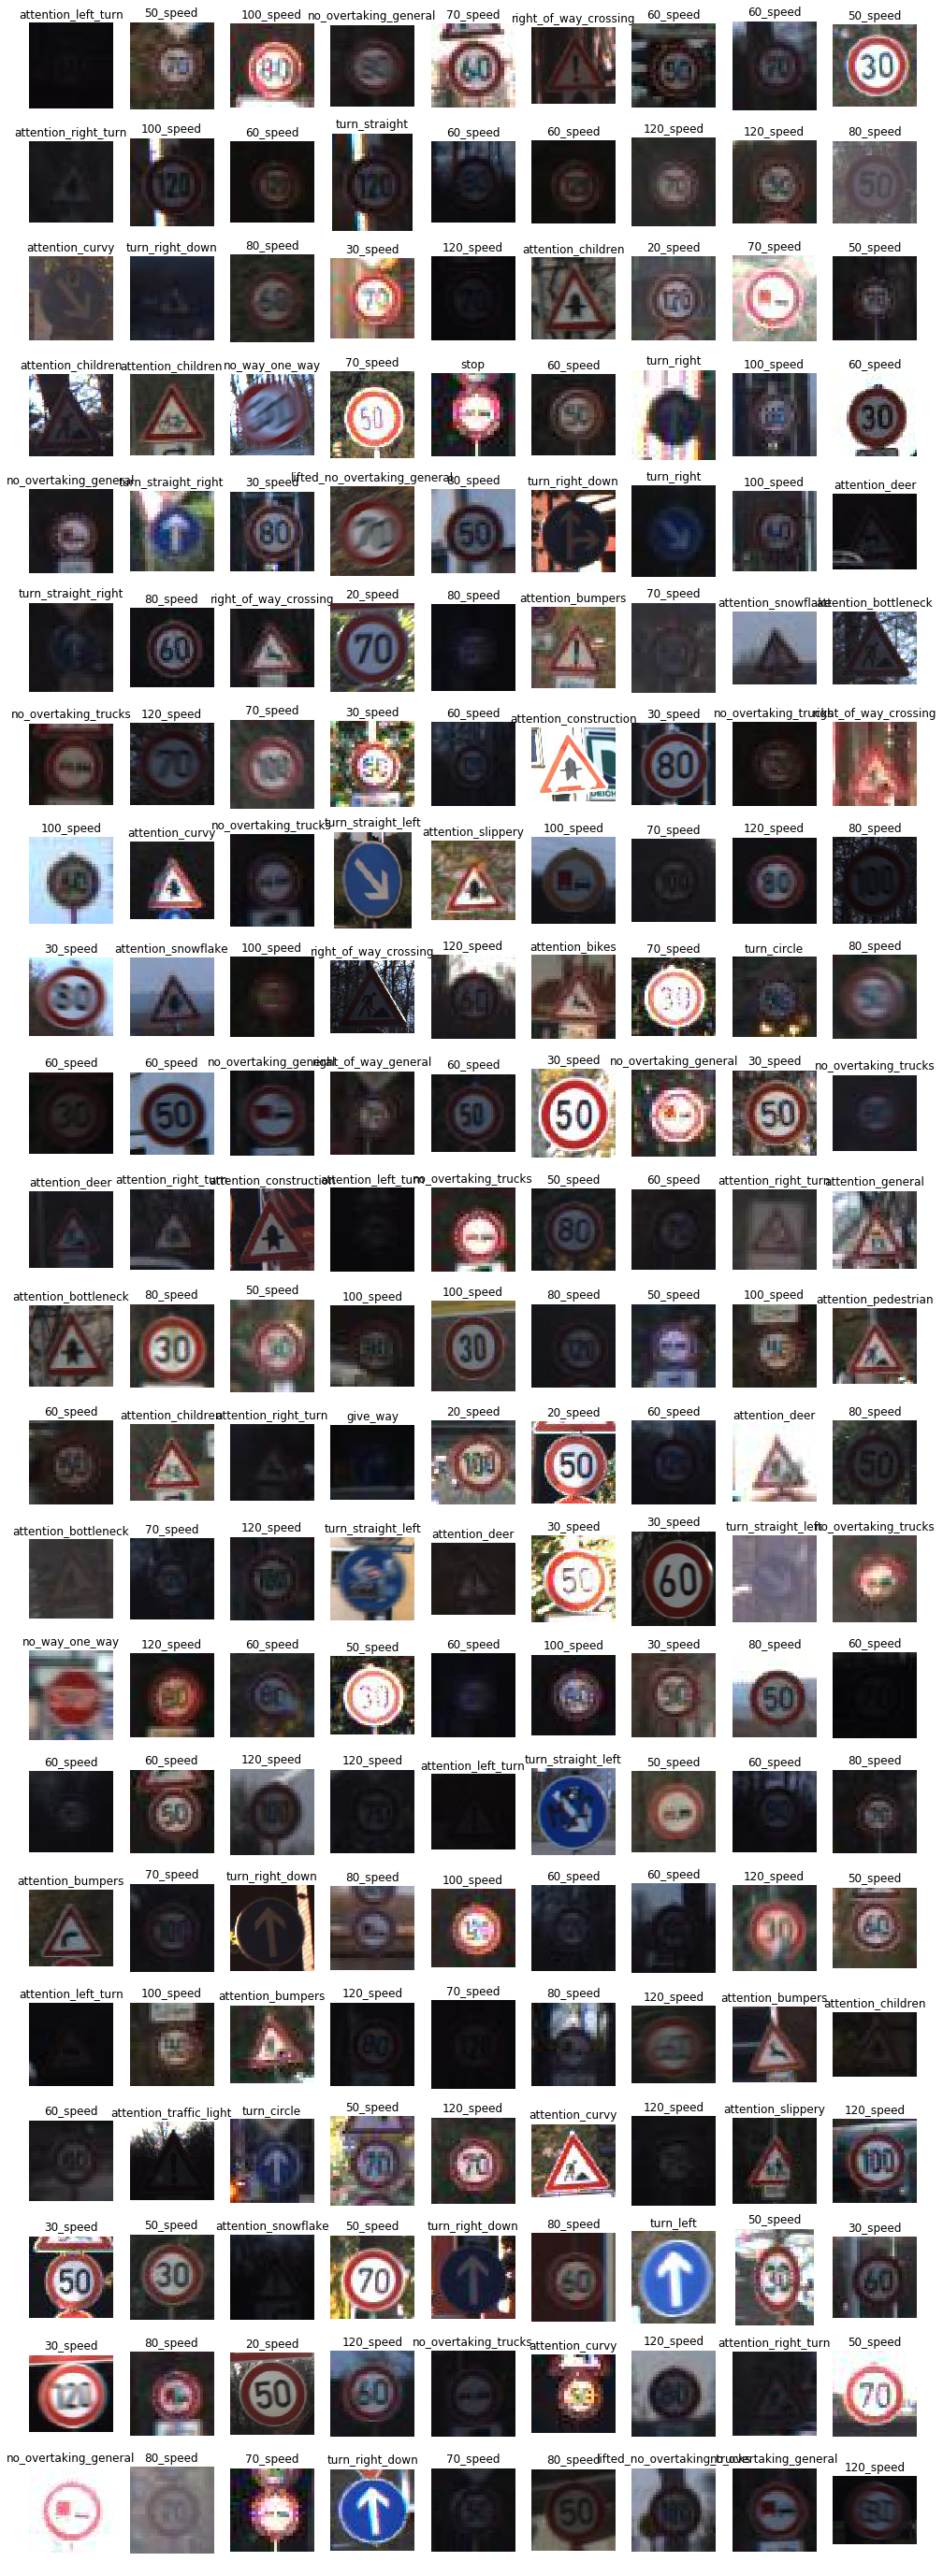

In [27]:
#Copy/paste of results from the script above, so we can see which images were missclassified.
missclassified_images = {
"dataset/training/00001/00054_00009.jpg": "00004",
"dataset/training/00001/00054_00008.jpg": "00002",
"dataset/training/00001/00004_00025.jpg": "00005",
"dataset/training/00001/00052_00008.jpg": "00008",
"dataset/training/00001/00070_00029.jpg": "00017",
"dataset/training/00001/00032_00016.jpg": "00002",
"dataset/training/00001/00015_00010.jpg": "00007",
"dataset/training/00001/00062_00005.jpg": "00008",
"dataset/training/00001/00025_00021.jpg": "00005",
"dataset/training/00001/00070_00003.jpg": "00004",
"dataset/training/00001/00012_00010.jpg": "00008",
"dataset/training/00001/00012_00004.jpg": "00008",
"dataset/training/00001/00012_00005.jpg": "00003",
"dataset/training/00001/00021_00003.jpg": "00002",
"dataset/training/00001/00030_00008.jpg": "00002",
"dataset/training/00001/00012_00000.jpg": "00020",
"dataset/training/00001/00012_00019.jpg": "00003",
"dataset/training/00001/00022_00003.jpg": "00003",
"dataset/training/00001/00008_00006.jpg": "00007",
"dataset/training/00001/00022_00000.jpg": "00008",
"dataset/training/00001/00014_00021.jpg": "00034",
"dataset/training/00001/00049_00026.jpg": "00003",
"dataset/training/00001/00038_00026.jpg": "00003",
"dataset/training/00001/00072_00001.jpg": "00003",
"dataset/training/00001/00022_00012.jpg": "00003",
"dataset/training/00001/00047_00002.jpg": "00003",
"dataset/training/00001/00022_00007.jpg": "00003",
"dataset/training/00001/00023_00000.jpg": "00007",
"dataset/training/00001/00023_00001.jpg": "00007",
"dataset/training/00001/00070_00021.jpg": "00004",
"dataset/training/00001/00004_00014.jpg": "00007",
"dataset/training/00001/00023_00006.jpg": "00007",
"dataset/training/00001/00057_00019.jpg": "00002",
"dataset/training/00001/00004_00029.jpg": "00000",
"dataset/training/00002/00045_00006.jpg": "00003",
"dataset/training/00002/00010_00018.jpg": "00001",
"dataset/training/00002/00057_00015.jpg": "00017",
"dataset/training/00002/00057_00014.jpg": "00017",
"dataset/training/00002/00007_00005.jpg": "00004",
"dataset/training/00002/00015_00000.jpg": "00004",
"dataset/training/00002/00037_00009.jpg": "00005",
"dataset/training/00002/00064_00011.jpg": "00004",
"dataset/training/00002/00031_00027.jpg": "00003",
"dataset/training/00002/00073_00019.jpg": "00005",
"dataset/training/00002/00037_00020.jpg": "00005",
"dataset/training/00002/00015_00005.jpg": "00004",
"dataset/training/00002/00045_00000.jpg": "00005",
"dataset/training/00002/00010_00022.jpg": "00000",
"dataset/training/00002/00001_00004.jpg": "00004",
"dataset/training/00002/00018_00007.jpg": "00003",
"dataset/training/00002/00013_00001.jpg": "00001",
"dataset/training/00002/00045_00016.jpg": "00005",
"dataset/training/00002/00013_00028.jpg": "00001",
"dataset/training/00002/00037_00026.jpg": "00003",
"dataset/training/00002/00070_00003.jpg": "00008",
"dataset/training/00002/00033_00005.jpg": "00005",
"dataset/training/00002/00068_00010.jpg": "00005",
"dataset/training/00002/00068_00011.jpg": "00005",
"dataset/training/00002/00065_00012.jpg": "00001",
"dataset/training/00002/00033_00004.jpg": "00005",
"dataset/training/00002/00022_00023.jpg": "00001",
"dataset/training/00002/00044_00005.jpg": "00003",
"dataset/training/00002/00000_00000.jpg": "00005",
"dataset/training/00002/00014_00014.jpg": "00003",
"dataset/training/00002/00071_00010.jpg": "00001",
"dataset/training/00002/00063_00017.jpg": "00005",
"dataset/training/00002/00044_00029.jpg": "00000",
"dataset/training/00002/00008_00022.jpg": "00003",
"dataset/training/00002/00017_00027.jpg": "00000",
"dataset/training/00002/00068_00014.jpg": "00005",
"dataset/training/00002/00014_00021.jpg": "00005",
"dataset/training/00002/00041_00003.jpg": "00008",
"dataset/training/00002/00022_00005.jpg": "00004",
"dataset/training/00002/00029_00029.jpg": "00001",
"dataset/training/00002/00014_00019.jpg": "00005",
"dataset/training/00002/00011_00002.jpg": "00021",
"dataset/training/00002/00058_00004.jpg": "00004",
"dataset/training/00002/00074_00004.jpg": "00003",
"dataset/training/00002/00038_00025.jpg": "00001",
"dataset/training/00002/00041_00004.jpg": "00008",
"dataset/training/00002/00009_00012.jpg": "00004",
"dataset/training/00002/00039_00008.jpg": "00004",
"dataset/training/00002/00034_00023.jpg": "00001",
"dataset/training/00002/00031_00010.jpg": "00005",
"dataset/training/00002/00069_00019.jpg": "00004",
"dataset/training/00002/00051_00026.jpg": "00001",
"dataset/training/00002/00037_00016.jpg": "00005",
"dataset/training/00002/00043_00023.jpg": "00003",
"dataset/training/00002/00009_00011.jpg": "00001",
"dataset/training/00002/00040_00003.jpg": "00007",
"dataset/training/00002/00040_00002.jpg": "00007",
"dataset/training/00002/00070_00024.jpg": "00008",
"dataset/training/00002/00069_00022.jpg": "00004",
"dataset/training/00002/00070_00021.jpg": "00008",
"dataset/training/00002/00039_00019.jpg": "00001",
"dataset/training/00002/00045_00022.jpg": "00003",
"dataset/training/00002/00032_00020.jpg": "00003",
"dataset/training/00003/00007_00004.jpg": "00007",
"dataset/training/00003/00045_00000.jpg": "00007",
"dataset/training/00003/00013_00016.jpg": "00005",
"dataset/training/00003/00039_00006.jpg": "00008",
"dataset/training/00003/00040_00018.jpg": "00008",
"dataset/training/00003/00021_00002.jpg": "00008",
"dataset/training/00003/00003_00008.jpg": "00005",
"dataset/training/00003/00033_00014.jpg": "00005",
"dataset/training/00003/00011_00008.jpg": "00019",
"dataset/training/00003/00029_00006.jpg": "00002",
"dataset/training/00003/00003_00001.jpg": "00005",
"dataset/training/00003/00033_00027.jpg": "00008",
"dataset/training/00003/00030_00006.jpg": "00004",
"dataset/training/00003/00029_00001.jpg": "00009",
"dataset/training/00003/00044_00008.jpg": "00005",
"dataset/training/00003/00033_00020.jpg": "00001",
"dataset/training/00003/00010_00010.jpg": "00008",
"dataset/training/00003/00045_00008.jpg": "00001",
"dataset/training/00003/00025_00003.jpg": "00007",
"dataset/training/00003/00031_00029.jpg": "00001",
"dataset/training/00003/00028_00003.jpg": "00007",
"dataset/training/00004/00018_00028.jpg": "00041",
"dataset/training/00004/00007_00004.jpg": "00008",
"dataset/training/00004/00062_00000.jpg": "00001",
"dataset/training/00004/00054_00009.jpg": "00008",
"dataset/training/00004/00007_00011.jpg": "00008",
"dataset/training/00004/00018_00029.jpg": "00041",
"dataset/training/00004/00007_00007.jpg": "00005",
"dataset/training/00004/00023_00021.jpg": "00008",
"dataset/training/00004/00032_00002.jpg": "00008",
"dataset/training/00004/00007_00000.jpg": "00007",
"dataset/training/00004/00035_00003.jpg": "00003",
"dataset/training/00004/00021_00003.jpg": "00008",
"dataset/training/00004/00022_00009.jpg": "00008",
"dataset/training/00004/00038_00002.jpg": "00002",
"dataset/training/00004/00063_00002.jpg": "00012",
"dataset/training/00004/00038_00003.jpg": "00005",
"dataset/training/00004/00050_00000.jpg": "00007",
"dataset/training/00004/00012_00017.jpg": "00002",
"dataset/training/00004/00021_00005.jpg": "00003",
"dataset/training/00004/00044_00003.jpg": "00005",
"dataset/training/00004/00006_00001.jpg": "00002",
"dataset/training/00004/00024_00008.jpg": "00008",
"dataset/training/00004/00063_00004.jpg": "00007",
"dataset/training/00004/00060_00029.jpg": "00008",
"dataset/training/00004/00006_00023.jpg": "00000",
"dataset/training/00004/00027_00008.jpg": "00008",
"dataset/training/00004/00030_00000.jpg": "00008",
"dataset/training/00004/00020_00023.jpg": "00003",
"dataset/training/00004/00051_00026.jpg": "00001",
"dataset/training/00004/00009_00007.jpg": "00007",
"dataset/training/00004/00052_00004.jpg": "00002",
"dataset/training/00004/00009_00005.jpg": "00008",
"dataset/training/00004/00037_00028.jpg": "00008",
"dataset/training/00004/00020_00020.jpg": "00008",
"dataset/training/00004/00054_00003.jpg": "00003",
"dataset/training/00004/00023_00001.jpg": "00019",
"dataset/training/00004/00009_00000.jpg": "00002",
"dataset/training/00004/00031_00003.jpg": "00008",
"dataset/training/00004/00028_00016.jpg": "00003",
"dataset/training/00004/00010_00015.jpg": "00002",
"dataset/training/00005/00034_00016.jpg": "00003",
"dataset/training/00005/00010_00024.jpg": "00004",
"dataset/training/00005/00057_00001.jpg": "00001",
"dataset/training/00005/00007_00013.jpg": "00008",
"dataset/training/00005/00039_00013.jpg": "00008",
"dataset/training/00005/00057_00012.jpg": "00003",
"dataset/training/00005/00039_00006.jpg": "00010",
"dataset/training/00005/00001_00007.jpg": "00008",
"dataset/training/00005/00054_00025.jpg": "00002",
"dataset/training/00005/00055_00009.jpg": "00004",
"dataset/training/00005/00050_00005.jpg": "00003",
"dataset/training/00005/00021_00028.jpg": "00001",
"dataset/training/00005/00049_00003.jpg": "00003",
"dataset/training/00005/00050_00000.jpg": "00003",
"dataset/training/00005/00006_00002.jpg": "00008",
"dataset/training/00005/00056_00006.jpg": "00001",
"dataset/training/00005/00027_00028.jpg": "00008",
"dataset/training/00005/00024_00009.jpg": "00008",
"dataset/training/00005/00022_00026.jpg": "00008",
"dataset/training/00005/00044_00027.jpg": "00002",
"dataset/training/00005/00003_00002.jpg": "00007",
"dataset/training/00005/00011_00005.jpg": "00008",
"dataset/training/00005/00060_00002.jpg": "00007",
"dataset/training/00005/00017_00001.jpg": "00007",
"dataset/training/00005/00022_00001.jpg": "00008",
"dataset/training/00005/00011_00003.jpg": "00003",
"dataset/training/00005/00035_00018.jpg": "00003",
"dataset/training/00005/00024_00017.jpg": "00003",
"dataset/training/00005/00029_00028.jpg": "00001",
"dataset/training/00005/00053_00028.jpg": "00001",
"dataset/training/00005/00053_00000.jpg": "00007",
"dataset/training/00005/00030_00015.jpg": "00008",
"dataset/training/00005/00047_00002.jpg": "00007",
"dataset/training/00005/00053_00016.jpg": "00002",
"dataset/training/00005/00024_00015.jpg": "00003",
"dataset/training/00005/00053_00017.jpg": "00001",
"dataset/training/00005/00026_00024.jpg": "00008",
"dataset/training/00005/00054_00000.jpg": "00040",
"dataset/training/00005/00023_00003.jpg": "00008",
"dataset/training/00005/00052_00004.jpg": "00003",
"dataset/training/00005/00054_00007.jpg": "00007",
"dataset/training/00005/00020_00018.jpg": "00009",
"dataset/training/00005/00052_00016.jpg": "00003",
"dataset/training/00005/00054_00011.jpg": "00003",
"dataset/training/00005/00054_00004.jpg": "00003",
"dataset/training/00005/00028_00003.jpg": "00010",
"dataset/training/00007/00015_00003.jpg": "00008",
"dataset/training/00007/00045_00011.jpg": "00000",
"dataset/training/00007/00018_00016.jpg": "00008",
"dataset/training/00007/00034_00004.jpg": "00003",
"dataset/training/00007/00046_00020.jpg": "00003",
"dataset/training/00007/00025_00008.jpg": "00008",
"dataset/training/00007/00034_00007.jpg": "00010",
"dataset/training/00007/00006_00004.jpg": "00005",
"dataset/training/00007/00021_00007.jpg": "00008",
"dataset/training/00007/00000_00012.jpg": "00004",
"dataset/training/00007/00030_00009.jpg": "00008",
"dataset/training/00007/00003_00029.jpg": "00005",
"dataset/training/00007/00003_00006.jpg": "00004",
"dataset/training/00007/00016_00000.jpg": "00042",
"dataset/training/00007/00009_00014.jpg": "00004",
"dataset/training/00008/00015_00028.jpg": "00001",
"dataset/training/00008/00018_00006.jpg": "00035",
"dataset/training/00008/00001_00005.jpg": "00002",
"dataset/training/00008/00018_00010.jpg": "00007",
"dataset/training/00008/00030_00019.jpg": "00003",
"dataset/training/00008/00027_00011.jpg": "00005",
"dataset/training/00008/00041_00008.jpg": "00005",
"dataset/training/00008/00021_00004.jpg": "00005",
"dataset/training/00008/00042_00007.jpg": "00003",
"dataset/training/00008/00014_00011.jpg": "00004",
"dataset/training/00008/00042_00006.jpg": "00003",
"dataset/training/00008/00042_00004.jpg": "00004",
"dataset/training/00008/00024_00009.jpg": "00003",
"dataset/training/00008/00030_00004.jpg": "00007",
"dataset/training/00008/00030_00013.jpg": "00005",
"dataset/training/00008/00030_00012.jpg": "00010",
"dataset/training/00008/00030_00017.jpg": "00003",
"dataset/training/00008/00004_00005.jpg": "00007",
"dataset/training/00008/00016_00002.jpg": "00007",
"dataset/training/00008/00040_00003.jpg": "00005",
"dataset/training/00008/00001_00009.jpg": "00000",
"dataset/training/00008/00023_00015.jpg": "00003",
"dataset/training/00008/00037_00029.jpg": "00003",
"dataset/training/00008/00040_00012.jpg": "00005",
"dataset/training/00008/00040_00006.jpg": "00005",
"dataset/training/00008/00031_00002.jpg": "00005",
"dataset/training/00008/00028_00000.jpg": "00005",
"dataset/training/00008/00007_00008.jpg": "00005",
"dataset/training/00008/00040_00004.jpg": "00003",
"dataset/training/00009/00034_00003.jpg": "00004",
"dataset/training/00009/00034_00004.jpg": "00014",
"dataset/training/00009/00031_00023.jpg": "00010",
"dataset/training/00009/00031_00022.jpg": "00002",
"dataset/training/00009/00045_00003.jpg": "00000",
"dataset/training/00009/00048_00001.jpg": "00010",
"dataset/training/00009/00003_00008.jpg": "00040",
"dataset/training/00009/00022_00008.jpg": "00010",
"dataset/training/00009/00044_00010.jpg": "00010",
"dataset/training/00009/00006_00000.jpg": "00002",
"dataset/training/00009/00044_00002.jpg": "00001",
"dataset/training/00009/00047_00001.jpg": "00017",
"dataset/training/00009/00024_00002.jpg": "00010",
"dataset/training/00009/00047_00014.jpg": "00013",
"dataset/training/00009/00006_00009.jpg": "00005",
"dataset/training/00009/00025_00001.jpg": "00010",
"dataset/training/00010/00016_00019.jpg": "00009",
"dataset/training/00010/00016_00018.jpg": "00009",
"dataset/training/00010/00016_00024.jpg": "00009",
"dataset/training/00010/00026_00001.jpg": "00005",
"dataset/training/00010/00024_00019.jpg": "00007",
"dataset/training/00010/00044_00013.jpg": "00009",
"dataset/training/00010/00003_00008.jpg": "00004",
"dataset/training/00010/00003_00020.jpg": "00009",
"dataset/training/00010/00044_00003.jpg": "00009",
"dataset/training/00010/00056_00005.jpg": "00020",
"dataset/training/00010/00003_00016.jpg": "00009",
"dataset/training/00010/00030_00005.jpg": "00020",
"dataset/training/00010/00055_00017.jpg": "00003",
"dataset/training/00010/00003_00015.jpg": "00009",
"dataset/training/00010/00017_00000.jpg": "00009",
"dataset/training/00010/00029_00002.jpg": "00005",
"dataset/training/00010/00044_00023.jpg": "00009",
"dataset/training/00010/00032_00024.jpg": "00041",
"dataset/training/00010/00025_00011.jpg": "00003",
"dataset/training/00010/00037_00002.jpg": "00005",
"dataset/training/00010/00016_00010.jpg": "00009",
"dataset/training/00010/00046_00001.jpg": "00005",
"dataset/training/00011/00002_00026.jpg": "00025",
"dataset/training/00011/00039_00011.jpg": "00030",
"dataset/training/00011/00000_00003.jpg": "00026",
"dataset/training/00011/00019_00014.jpg": "00021",
"dataset/training/00011/00041_00009.jpg": "00025",
"dataset/training/00011/00000_00014.jpg": "00031",
"dataset/training/00011/00019_00017.jpg": "00028",
"dataset/training/00011/00000_00011.jpg": "00028",
"dataset/training/00011/00038_00022.jpg": "00018",
"dataset/training/00011/00011_00003.jpg": "00023",
"dataset/training/00011/00005_00002.jpg": "00025",
"dataset/training/00011/00040_00001.jpg": "00020",
"dataset/training/00011/00043_00021.jpg": "00028",
"dataset/training/00011/00043_00023.jpg": "00024",
"dataset/training/00011/00031_00012.jpg": "00021",
"dataset/training/00011/00032_00022.jpg": "00025",
"dataset/training/00011/00032_00021.jpg": "00025",
"dataset/training/00013/00052_00008.jpg": "00020",
"dataset/training/00013/00064_00000.jpg": "00020",
"dataset/training/00013/00052_00004.jpg": "00020",
"dataset/training/00013/00001_00008.jpg": "00038",
"dataset/training/00014/00006_00000.jpg": "00017",
"dataset/training/00018/00015_00000.jpg": "00026",
"dataset/training/00018/00015_00006.jpg": "00026",
"dataset/training/00018/00012_00004.jpg": "00030",
"dataset/training/00018/00035_00001.jpg": "00031",
"dataset/training/00018/00033_00007.jpg": "00019",
"dataset/training/00018/00027_00016.jpg": "00011",
"dataset/training/00018/00027_00000.jpg": "00031",
"dataset/training/00018/00017_00003.jpg": "00030",
"dataset/training/00018/00029_00004.jpg": "00022",
"dataset/training/00018/00033_00020.jpg": "00026",
"dataset/training/00018/00015_00009.jpg": "00026",
"dataset/training/00020/00005_00012.jpg": "00021",
"dataset/training/00020/00005_00000.jpg": "00028",
"dataset/training/00020/00010_00017.jpg": "00022",
"dataset/training/00022/00004_00000.jpg": "00026",
"dataset/training/00023/00005_00006.jpg": "00026",
"dataset/training/00023/00008_00005.jpg": "00020",
"dataset/training/00023/00008_00002.jpg": "00019",
"dataset/training/00023/00016_00000.jpg": "00031",
"dataset/training/00024/00005_00006.jpg": "00018",
"dataset/training/00025/00032_00005.jpg": "00022",
"dataset/training/00025/00039_00003.jpg": "00031",
"dataset/training/00025/00004_00023.jpg": "00021",
"dataset/training/00025/00004_00021.jpg": "00021",
"dataset/training/00025/00018_00005.jpg": "00022",
"dataset/training/00025/00032_00000.jpg": "00021",
"dataset/training/00025/00020_00006.jpg": "00031",
"dataset/training/00025/00006_00004.jpg": "00030",
"dataset/training/00025/00000_00016.jpg": "00011",
"dataset/training/00025/00047_00027.jpg": "00011",
"dataset/training/00025/00014_00005.jpg": "00028",
"dataset/training/00025/00038_00012.jpg": "00027",
"dataset/training/00025/00027_00002.jpg": "00020",
"dataset/training/00025/00047_00009.jpg": "00024",
"dataset/training/00025/00024_00008.jpg": "00026",
"dataset/training/00025/00030_00009.jpg": "00028",
"dataset/training/00025/00005_00012.jpg": "00024",
"dataset/training/00025/00024_00000.jpg": "00019",
"dataset/training/00025/00002_00000.jpg": "00011",
"dataset/training/00025/00009_00000.jpg": "00020",
"dataset/training/00025/00004_00002.jpg": "00021",
"dataset/training/00026/00003_00009.jpg": "00028",
"dataset/training/00026/00003_00004.jpg": "00025",
"dataset/training/00026/00011_00002.jpg": "00023",
"dataset/training/00027/00003_00016.jpg": "00025",
"dataset/training/00027/00005_00004.jpg": "00026",
"dataset/training/00027/00005_00003.jpg": "00031",
"dataset/training/00028/00005_00000.jpg": "00023",
"dataset/training/00029/00008_00007.jpg": "00028",
"dataset/training/00029/00008_00000.jpg": "00028",
"dataset/training/00030/00006_00004.jpg": "00038",
"dataset/training/00030/00006_00003.jpg": "00038",
"dataset/training/00030/00010_00003.jpg": "00025",
"dataset/training/00030/00010_00000.jpg": "00020",
"dataset/training/00031/00002_00008.jpg": "00038",
"dataset/training/00031/00020_00013.jpg": "00022",
"dataset/training/00031/00021_00005.jpg": "00030",
"dataset/training/00031/00012_00001.jpg": "00029",
"dataset/training/00031/00021_00008.jpg": "00030",
"dataset/training/00031/00019_00025.jpg": "00023",
"dataset/training/00031/00025_00005.jpg": "00029",
"dataset/training/00031/00002_00000.jpg": "00020",
"dataset/training/00031/00004_00002.jpg": "00011",
"dataset/training/00031/00002_00006.jpg": "00038",
"dataset/training/00033/00021_00028.jpg": "00034",
"dataset/training/00033/00012_00002.jpg": "00013",
"dataset/training/00033/00014_00005.jpg": "00034",
"dataset/training/00033/00012_00001.jpg": "00020",
"dataset/training/00033/00021_00025.jpg": "00034",
"dataset/training/00034/00002_00026.jpg": "00037",
"dataset/training/00034/00000_00008.jpg": "00035",
"dataset/training/00035/00001_00001.jpg": "00033",
"dataset/training/00035/00032_00001.jpg": "00036",
"dataset/training/00035/00028_00022.jpg": "00038",
"dataset/training/00035/00027_00007.jpg": "00020",
"dataset/training/00035/00022_00025.jpg": "00038",
"dataset/training/00035/00006_00029.jpg": "00038",
"dataset/training/00035/00038_00026.jpg": "00034",
"dataset/training/00035/00009_00012.jpg": "00037",
"dataset/training/00035/00004_00004.jpg": "00040",
"dataset/training/00035/00002_00001.jpg": "00036",
"dataset/training/00036/00000_00022.jpg": "00038",
"dataset/training/00036/00000_00020.jpg": "00038",
"dataset/training/00036/00010_00004.jpg": "00037",
"dataset/training/00036/00004_00000.jpg": "00037",
"dataset/training/00036/00007_00008.jpg": "00006",
"dataset/training/00036/00002_00013.jpg": "00034",
"dataset/training/00038/00039_00029.jpg": "00037",
"dataset/training/00038/00039_00028.jpg": "00037",
"dataset/training/00038/00001_00028.jpg": "00037",
"dataset/training/00038/00020_00000.jpg": "00036",
"dataset/training/00038/00048_00029.jpg": "00037",
"dataset/training/00038/00030_00002.jpg": "00033",
"dataset/training/00038/00005_00001.jpg": "00037",
"dataset/training/00038/00046_00006.jpg": "00042",
"dataset/training/00038/00013_00027.jpg": "00021",
"dataset/training/00038/00034_00009.jpg": "00039",
"dataset/training/00038/00028_00000.jpg": "00039",
"dataset/training/00038/00039_00027.jpg": "00037"
}

limit_images = 198
i = 0
plt.figure(figsize=(17, 50))
for image, label in missclassified_images.items():
    plt.subplot(22,9, i + 1)
    plt.axis('off')
    plt.title("{}".format(label_map[int(label)]))
    i += 1
    plt.imshow(Image.open(image))
    if i is limit_images:
        break
plt.show()

## Model evaluation

For model evaluation we'll use script that were described in TensorFlow for Poets codelab. The code below is just a copy/paste of [label_image.py](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/label_image/label_image.py), with small modifications to label more images at once.

In [19]:
def load_graph(model_file):
  graph = tf.Graph()
  graph_def = tf.GraphDef()

  with open(model_file, "rb") as f:
    graph_def.ParseFromString(f.read())
  with graph.as_default():
    tf.import_graph_def(graph_def)

  return graph


def read_tensor_from_image_file(file_name,
                                input_height=299,
                                input_width=299,
                                input_mean=0,
                                input_std=255):
  input_name = "file_reader"
  output_name = "normalized"
  file_reader = tf.read_file(file_name, input_name)
  if file_name.endswith(".png"):
    image_reader = tf.image.decode_png(
        file_reader, channels=3, name="png_reader")
  elif file_name.endswith(".gif"):
    image_reader = tf.squeeze(
        tf.image.decode_gif(file_reader, name="gif_reader"))
  elif file_name.endswith(".bmp"):
    image_reader = tf.image.decode_bmp(file_reader, name="bmp_reader")
  else:
    image_reader = tf.image.decode_jpeg(
        file_reader, channels=3, name="jpeg_reader")
  float_caster = tf.cast(image_reader, tf.float32)
  dims_expander = tf.expand_dims(float_caster, 0)
  resized = tf.image.resize_bilinear(dims_expander, [input_height, input_width])
  normalized = tf.divide(tf.subtract(resized, [input_mean]), [input_std])
  sess = tf.Session()
  result = sess.run(normalized)

  return result


def load_labels(label_file):
  label = []
  proto_as_ascii_lines = tf.gfile.GFile(label_file).readlines()
  for l in proto_as_ascii_lines:
    label.append(l.rstrip())
  return label

In [20]:
graph = load_graph(OUTPUT_RETRAINED_GRAPH)
input_name = "import/" + MODEL_INPUT_LAYER_NAME
output_name = "import/" + MODEL_OUTPUT_LAYER_NAME
input_operation = graph.get_operation_by_name(input_name)
output_operation = graph.get_operation_by_name(output_name)

Pick 20 random images and make classification for each of them. 

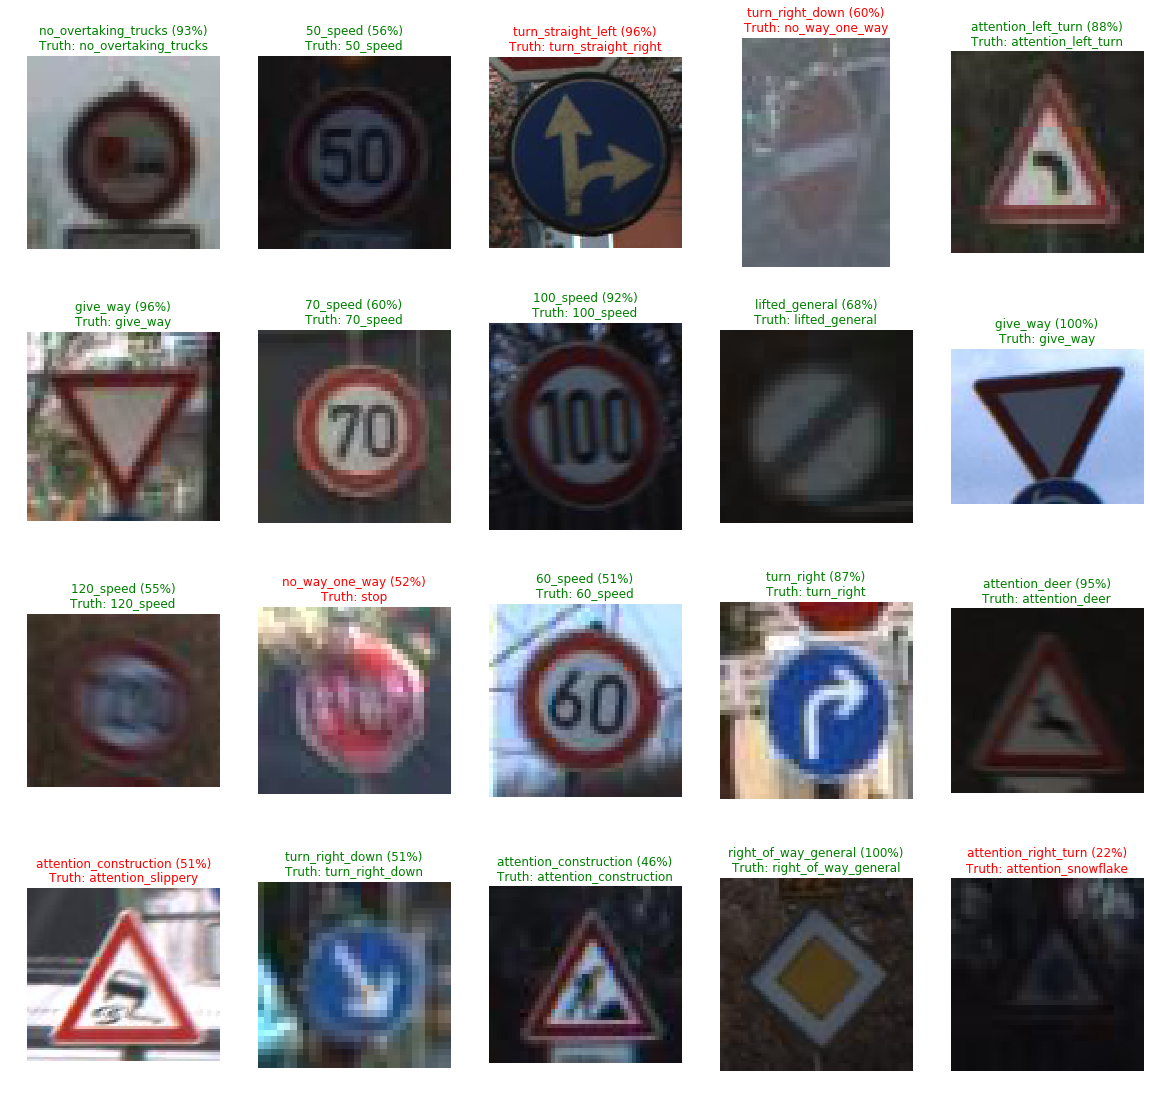

In [21]:
sample_indexes = random.sample(range(len(validation_images)), 20)
validation_samples = [(validation_images[i], validation_labels[i]) for i in sample_indexes]

i = 0
fig = plt.figure(figsize=(20, 100))
for sample_image, sample_label in validation_samples:
    true_label = label_map[sample_label]
    image_tensor = read_tensor_from_image_file(
      sample_image,
      input_height=MODEL_INPUT_HEIGHT,
      input_width=MODEL_INPUT_WIDTH,
      input_mean=MODEL_INPUT_MEAN,
      input_std=MODEL_INPUT_STD
    )

    with tf.Session(graph=graph) as sess:
        results = sess.run(output_operation.outputs[0], {
            input_operation.outputs[0]: image_tensor
        })
        results = np.squeeze(results)

    top_index = results.argmax()
    predicted_label = label_map[top_index]
    plt.subplot(20, 5,1 + i)
    i += 1
    plt.imshow(Image.open(sample_image))
    plt.axis('off')
    color='green' if predicted_label == true_label else 'red'
    plt.title("{} ({:2.0f}%)\nTruth: {}".format(predicted_label, 100 * results[top_index], true_label), color=color)

## Convert model to TensorFlow Lite

In [22]:
%%time
!tflite_convert \
  --output_file={OUTPUT_TFLITE_MODEL} \
  --graph_def_file={OUTPUT_RETRAINED_GRAPH} \
  --input_arrays={MODEL_INPUT_LAYER_NAME} \
  --output_arrays={MODEL_OUTPUT_LAYER_NAME}

2019-02-18 23:43:53.852668: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
CPU times: user 270 ms, sys: 120 ms, total: 390 ms
Wall time: 12.2 s


(⚠️📲👀)

Learn more about our TensorFlow Lite model. You need to know those information when you will implement model in client app (Android, iOS, anything else using TensorFlow Lite).

In [23]:
# Load TensorFlow lite model
interpreter = tf.contrib.lite.Interpreter(model_path=OUTPUT_TFLITE_MODEL)
interpreter.allocate_tensors()

print("== Input details ==")
print("name:", interpreter.get_input_details()[0]['name'])
print("shape:", interpreter.get_input_details()[0]['shape'])
print("type:", interpreter.get_input_details()[0]['dtype'])

print("\n== Output details ==")
print("name:", interpreter.get_output_details()[0]['name'])
print("shape:", interpreter.get_output_details()[0]['shape'])
print("type:", interpreter.get_output_details()[0]['dtype'])

print("\nDUMP INPUT")
print(interpreter.get_input_details()[0])
print("\nDUMP OUTPUT")
print(interpreter.get_output_details()[0])

== Input details ==
name: Placeholder
shape: [  1 224 224   3]
type: <class 'numpy.float32'>

== Output details ==
name: final_result
shape: [ 1 43]
type: <class 'numpy.float32'>

DUMP INPUT
{'shape': array([  1, 224, 224,   3], dtype=int32), 'index': 0, 'name': 'Placeholder', 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0)}

DUMP OUTPUT
{'shape': array([ 1, 43], dtype=int32), 'index': 1, 'name': 'final_result', 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0)}


### TensorFlow Lite model evaluation

Make sure our TF Lite model is still working after the conversion. Just compare output value with the one from the example above (we'll classify just the first image). Is it the same? Yes? You can start implementing TFLite model in your application. 🙂



Prediction results: [[9.9312310e-06 1.1518342e-05 3.2137352e-05 1.4739865e-04 8.1511380e-06
  8.6716010e-04 1.0435610e-05 1.4108795e-04 6.5147418e-05 4.5425954e-04
  9.2832679e-01 1.8959058e-06 6.7650167e-06 2.3311502e-06 8.7976186e-06
  1.5018261e-03 6.8317384e-02 1.7367565e-05 1.1575036e-06 1.7572564e-06
  6.5924119e-06 1.5808295e-07 7.5981311e-06 7.9934847e-07 2.1121391e-08
  7.6386465e-07 4.1371922e-07 8.2471854e-07 4.2220995e-07 3.8388453e-06
  4.1059047e-07 4.1223348e-06 2.8740835e-05 1.4735346e-07 3.0140955e-06
  1.5023188e-06 4.0380488e-07 5.6733558e-07 4.8410715e-07 2.4120419e-08
  1.3921598e-07 8.2464385e-07 5.0629237e-06]]

Predicted value: no_overtaking_trucks (93%)


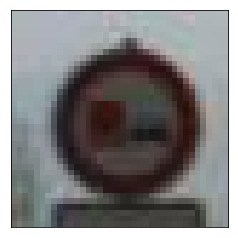

In [24]:
example_img_for_tflite = validation_samples[0][0]

plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.imshow(Image.open(example_img_for_tflite), cmap=plt.cm.binary)

image_tensor = read_tensor_from_image_file(
    example_img_for_tflite,
    input_height=MODEL_INPUT_HEIGHT,
    input_width=MODEL_INPUT_WIDTH,
    input_mean=MODEL_INPUT_MEAN,
    input_std=MODEL_INPUT_STD
)

input_details = interpreter.get_input_details()
interpreter.set_tensor(input_details[0]['index'], image_tensor)

interpreter.invoke()

output_details = interpreter.get_output_details()
output_data = interpreter.get_tensor(output_details[0]['index'])
single_result = np.argmax(output_data)
print("\n\nPrediction results:", output_data)
print("\nPredicted value: {} ({:2.0f}%)".format(label_map[single_result], output_data[0][single_result] * 100))